In [40]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import pandas as pd

import devkit.api as dk
import finkit.api as fk
import DataAPI
import Factor.api as factor
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import train_test_split 
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
# xgb_clf = XGBClassifier()
# xgb_clf_cv = cross_val_score(xgb_clf, X_train, y_train, cv=10)

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


E:\06_software\Anoconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 设置宏观参数

In [3]:
schema = pd.DataFrame(DataAPI.schema.get_schema("indicator")).T
inds_ts = schema[schema.type == '时间序列'].index.tolist()
inds_fr = schema[schema.type == '财报数据'].index.tolist()

In [35]:
trading_days_ts = fk.get_monthly_last_trading_days(start="2006-01-01", end="2018-05-31")
# trading_days_fr = fk.get_report_days(start="2016-01-01", end="2016-12-31")
# 报告日根据date匹配date_available

# 确定股票池

## 方案4
- 剔除次新股（ipo_listdays<500)
- 停牌股（最高价=最低价）
- 剔除亏损股票（PE<0)
- 按流通市值升序排序， 取中位数介于0.75-0.95之间的股票
- 返回各日期入选股票的字典 sec_ids {date: [股票列表]}

In [29]:
schema = pd.DataFrame(DataAPI.schema.get_schema("indicator")).T
inds_ts = schema[schema.type == '时间序列'].index.tolist()
inds_fr = schema[schema.type == '财报数据'].index.tolist()
# sec_ids为空表示全A股
sec_ids = pd.read_csv(r"E:\07_data\02_factor\temp_data\zz500.csv")['wind_code'].tolist()  # zz500
# 流通市值介于LP与UP之间
LP = 0.05 
UP = 0.95
NEW_CP = 100 # 小于此值为次新股
def dict2df(ind, trading_days):
    df_ind = DataAPI.read.get_secs_indicator_on_multidays(indicator=ind, sec_ids=sec_ids, trading_days=trading_days)
    output = pd.DataFrame()
    for date in df_ind:
        df = df_ind[date]
        df['date'] = date
        output = output.append(df)
    return output
mkt_cap_float = dict2df('MKT_CAP_FLOAT', trading_days_ts)
ipo_listdays = dict2df('IPO_LISTDAYS', trading_days_ts)
low = dict2df('LOW', trading_days_ts)
high = dict2df('HIGH', trading_days_ts)
pe = dict2df('VAL_PE_DEDUCTED_TTM', trading_days_ts)

df_sec_ids = mkt_cap_float.merge(ipo_listdays, how='inner', on=['sec_id', 'date'])
df_sec_ids = df_sec_ids.merge(low, how='inner', on=['sec_id', 'date'])
df_sec_ids = df_sec_ids.merge(high, how='inner', on=['sec_id', 'date'])
df_sec_ids = df_sec_ids.merge(pe, how='inner', on=['sec_id', 'date'])

df_sec_ids = df_sec_ids[df_sec_ids.VAL_PE_DEDUCTED_TTM > 0] # 剔除亏损股票
df_sec_ids = df_sec_ids[df_sec_ids.HIGH != df_sec_ids.LOW] # 剔除停牌股
df_sec_ids = df_sec_ids[df_sec_ids.IPO_LISTDAYS >= NEW_CP] # 剔除次新股

a=df_sec_ids.groupby(['date']).MKT_CAP_FLOAT.quantile(LP).to_frame().reset_index().rename(columns={'MKT_CAP_FLOAT': "size_LP"})
df_sec_ids = df_sec_ids.merge(a, how='inner', on=['date'])
a=df_sec_ids.groupby(['date']).MKT_CAP_FLOAT.quantile(UP).to_frame().reset_index().rename(columns={'MKT_CAP_FLOAT': "size_UP"})
df_sec_ids = df_sec_ids.merge(a, how='inner', on=['date'])

df_sec_ids = df_sec_ids[df_sec_ids.MKT_CAP_FLOAT.between(df_sec_ids['size_LP'], df_sec_ids['size_UP'])]

sec_ids = {}
date_list = list(set(df_sec_ids['date']))
for date in date_list:
    sec_ids[date] = list(df_sec_ids[df_sec_ids['date'] == date]['sec_id'])

In [30]:
# 观察每个月入选股票数量
df_sec_ids.groupby('date').size()

date
2005-04-29    176
2005-05-31    169
2005-06-30    161
2005-07-29    175
2005-08-31    187
2005-09-30    175
2005-10-31    158
2005-11-30    155
2005-12-30    151
2006-01-25    155
2006-02-28    149
2006-03-31    148
2006-04-28    157
2006-05-31    164
2006-06-30    155
2006-07-31    171
2006-08-31    190
2006-09-29    188
2006-10-31    173
2006-11-30    178
2006-12-29    177
2007-01-31    179
2007-02-28    180
2007-03-30    198
2007-04-30    178
2007-05-31    180
2007-06-29    174
2007-07-31    185
2007-08-31    203
2007-09-28    206
             ... 
2015-12-31    316
2016-01-29    314
2016-02-29    316
2016-03-31    321
2016-04-29    325
2016-05-31    323
2016-06-30    325
2016-07-29    324
2016-08-31    328
2016-09-30    323
2016-10-31    340
2016-11-30    336
2016-12-30    338
2017-01-26    336
2017-02-28    336
2017-03-31    352
2017-04-28    353
2017-05-31    358
2017-06-30    361
2017-07-31    357
2017-08-31    382
2017-09-29    388
2017-10-31    390
2017-11-30    383
2017-

In [32]:
# 1. 特征
schema = pd.DataFrame(DataAPI.schema.get_schema("indicator")).T
schema = schema[~schema.aspect.isin(['辅助指标', '价量指标'])]
inds_ts = schema[schema.type == '时间序列'].index.tolist()
# 这几个特征暂时没取完 为了避免下面的读写错误 先删除这个变量
# inds_ts.remove('RSI_60D')
# inds_ts.remove('RSI_120D')
# inds_ts.remove('RSI_20D')
# inds_ts.remove('SI')
# inds_ts.remove("USDX")
# inds_ts.remove("USDCNY")
# inds_ts.remove("DR001")
# inds_ts.remove("DR007")
# inds_ts.remove("SHIBORON")
# inds_ts.remove("TB1Y")
# inds_ts.remove("TB5Y")
# inds_ts.remove("TB10Y")
# inds_ts.remove("LPR1Y") 
inds_ts.remove('TECH_CRY')
inds_ts.remove('TECH_MAWVAD')
inds_ts.remove('TECH_PSY')
inds_ts.remove('TECH_REVS10')
inds_ts.remove('TECH_REVS120')
inds_ts.remove('TECH_REVS20INDU1')
inds_ts.remove('TECH_REVS250')
inds_ts.remove('TECH_REVS5')
inds_ts.remove('TECH_REVS5INDU1')
inds_ts.remove('TECH_REVS60')
inds_ts.remove('TECH_REVS750')
inds_ts.remove('TECH_TURNOVERRATE10')
inds_ts.remove('TECH_TURNOVERRATE120')
inds_ts.remove('TECH_TURNOVERRATE20')
inds_ts.remove('TECH_TURNOVERRATE240')
inds_ts.remove('TECH_TURNOVERRATE5')
inds_ts.remove("TECH_TURNOVERRATE60")
inds_fr = schema[schema.type == '财报数据'].index.tolist()

# 获取指标

In [36]:
# 时间序列指标
df_inds=pd.DataFrame()
for ind in inds_ts:
    df_ind = pd.DataFrame()
    for date in trading_days_ts:   
        a = DataAPI.read.get_secs_indicator(indicator=ind, sec_ids=sec_ids[date], date=date).reset_index()
        a['date'] = date
        df_ind = df_ind.append(a)
    if len(df_inds) == 0:
        df_inds = df_ind.copy()
    else:
        df_inds = df_inds.merge(df_ind, how='outer', on=['sec_id', 'date'])

# 财务报表指标
df_inds['date_available'] = df_inds['date'].apply(lambda x: dk.get_available_report_day(x))
report_days_to_load = list(set(df_inds['date_available']))
secs_list_temp = list(set(df_inds['sec_id']))  # 由于财报数据取报告日 为了保证所有需要股票都取到 取时间序列指标各月末入选股票的并集
df_frs=pd.DataFrame()
for ind in inds_fr:
    df_fr = pd.DataFrame()
    for date in report_days_to_load:
        a = DataAPI.read.get_secs_indicator(indicator=ind, sec_ids=secs_list_temp, date=date).reset_index()
        a['date'] = date
        df_fr = df_fr.append(a)
    if len(df_frs) == 0:
        df_frs = df_fr.copy()
    else:
        df_frs = df_frs.merge(df_fr, how='outer', on=['sec_id', 'date'])
df_frs = df_frs.rename(columns={'date': 'date_available'})
df_inds = df_inds.merge(df_frs, how='left', on=['sec_id', 'date_available'])

In [37]:
# 针对个别的指标进行处理
# 删除缺失过多的特征 然后删除缺失样本
def drop_overmissing_feats(dsi, threshold):
    """
    删除缺失过多的特征  然后剔除有缺失值的样本
    """
    a = dsi.isnull().sum() / len(dsi) < threshold
    feats_to_retain = a[a].index
    dsi = dsi[feats_to_retain].dropna()
    dsi = dsi.reset_index()
    del dsi['index']
    return dsi
    # del df_raw['sec_id']
    # del train['group_id']
df_inds = drop_overmissing_feats(df_inds, 0.1)

# 将估值类指标取倒数
df_inds['VAL_PE_DEDUCTED_TTM'] = 1 / df_inds['VAL_PE_DEDUCTED_TTM'] 
df_inds['PS_TTM'] = 1 / df_inds['PS_TTM'] 
df_inds['PCF_OCF_TTM'] = 1 / df_inds['PCF_OCF_TTM'] 
df_inds['PB_LF'] = 1 / df_inds['PB_LF'] 
# 流通市值取对数
df_inds['MKT_CAP_FLOAT'] = np.log(df_inds['MKT_CAP_FLOAT'])

In [39]:
df_inds.shape

(33688, 39)

# 获取下个月收益率

In [78]:
df_inds['yearmonth'] = df_inds['date'].apply(lambda x: dk.date2char(dk.char2datetime(x) +  dk.timedelta({'months': 1}))[:7])

def derive_next_month_rr(sec_ids):
    """
    获取给定股票列表在给定日期列表的下个月收益率
    @sec_ids <list>: 股票列表
    """
    # 取月初月末的交易日列表
    tds = pd.read_csv(r"E:\07_data\02_factor\temp_data\trading_days.csv")
    tds['group'] = tds['date'].apply(lambda x: x[:7])
    tds = tds.sort_values(['date'])
    first = tds.groupby('group').head(1)
    last = tds.groupby('group').tail(1)
    tds=first.append(last)
    tds = tds.sort_values('date')

    # 获取月初月末交易日的收盘价
    close = factor.get_secs_index(index="close", trading_days=tds.date.tolist(), sec_ids=sec_ids)
    close = close.sort_values(['sec_id', 'date'])
    close['yearmonth'] = close['date'].apply(lambda x: x[:7])

    # 获取月收益率
    def cal_ret(x):
        close_id = x.columns.tolist().index('close')
        return x.iloc[-1, close_id]/x.iloc[0, close_id] - 1
    df_return=close.groupby(['sec_id', 'yearmonth'], as_index=False).apply(lambda x: cal_ret(x))
    df_return=df_return.reset_index().rename(columns={0: 'month_ret'})
    return df_return

df_return = derive_next_month_rr(list(set(df_inds['sec_id'])))
df_raw=df_inds.merge(df_return, how='inner', on=['sec_id', 'yearmonth'])
yearmonth = sorted(list(set(df_raw.yearmonth)))
group_id = pd.DataFrame(yearmonth, columns=['yearmonth'], index=range(1, len(yearmonth)+1))
group_id = group_id.sort_values(['yearmonth'])
group_id = group_id.reset_index().rename(columns={'index': 'group_id'})
df_raw = df_raw.merge(group_id, how='left', on=['yearmonth'])

# 获得标签

In [79]:
# 方案1 label_A 分位数法  次月收率处于同期前30%的为1（强势股） 位于后30%的为0（弱势股）
def derive_label_A(dsi, lp=0.3, up=0.7):
    """
    根据给定的数据集dsi计算标签
    @up <int>: 上限 大于此值为强势股 记为1
    @lp <int>: 下限 小于于此值为弱势股 记为0
    """
    df_lp = dsi.groupby(['yearmonth']).month_ret.apply(lambda x: x.quantile(lp)).reset_index().rename(columns={'month_ret': 'lp'})
    df_up = dsi.groupby(['yearmonth']).month_ret.apply(lambda x: x.quantile(up)).reset_index().rename(columns={'month_ret': 'up'})
    dsi = dsi.merge(df_lp, how='left', on='yearmonth')
    dsi = dsi.merge(df_up, how='left', on='yearmonth')
    for i in dsi.index:
        if dsi.loc[i, 'month_ret'] < dsi.loc[i, 'lp']:
            dsi.loc[i, 'good_yn'] = 0
        elif dsi.loc[i, 'month_ret'] > dsi.loc[i, 'up']:
            dsi.loc[i, 'good_yn'] = 1
        else:
            dsi.loc[i, 'good_yn'] = np.nan
    del dsi['lp']
    del dsi['up']
    del dsi['month_ret']
    dsi = dsi[~dsi.good_yn.isnull()]
    return dsi

# 方案2 label_B 绝对收益法    次月收益率>0 为1 否则为0
def derive_label_B(dsi):
    """
    根据给定的数据集dsi计算标签
    """
    dsi['good_yn'] = (dsi['month_ret'] > 0) * 1

    del dsi['month_ret']
    dsi = dsi[~dsi.good_yn.isnull()]
    return dsi

df_raw = derive_label_A(df_raw)

df_raw.to_csv(r"E:\07_data\02_factor\temp_data\df_raw_label_A.csv")

# 划分数据集

In [38]:
df_raw = pd.read_csv(r"E:\07_data\02_factor\temp_data\df_raw_label_A.csv", index_col=0)
# train_period = fk.get_monthly_last_trading_days(start="2008-11-07", end="2009-08-04") # 训练集牛市
# test_period = fk.get_monthly_last_trading_days(start="2014-07-30", end="2015-06-15") # 测试集牛市
# 下面时间段效果较好
# train_period = fk.get_monthly_last_trading_days(start="2009-08-05", end="2014-07-30") # 训练集震荡市
# test_period = fk.get_monthly_last_trading_days(start="2016-01-29", end="2017-12-31") # 测试集震荡市
train_period = {}
test_period = {}
for i in range(1, 8):
    train_period[i] = fk.get_monthly_last_trading_days(start="{}-01-01".format(2005+i), end="{}-12-31".format(2005+i+4))
    test_period[i] = fk.get_monthly_last_trading_days(start="{}-01-01".format(2005+i+4+1), end="{}-12-31".format(2005+i+4+1))
df_train = {}
df_test = {}
for i in range(1, 8):
    df_train[i] = df_raw[df_raw.date.isin(train_period[i])].copy()
    df_test[i] = df_raw[df_raw.date.isin(test_period[i])].copy()
    df_train[i].to_csv(r"E:\07_data\02_factor\temp_data\df_train{}.csv".format(i))
    df_test[i].to_csv(r"E:\07_data\02_factor\temp_data\df_test{}.csv".format(i))
    
# 将数据存入文件
f = open(r"E:\07_data\02_factor\temp_data\df_train.txt", 'wb')
pickle.dump( df_train, f, 0 )
f.close()
f = open(r"E:\07_data\02_factor\temp_data\df_test.txt", 'wb')
pickle.dump( df_test, f, 0 )
f.close()

In [52]:
f = open(r"E:\07_data\02_factor\temp_data\df_train.txt", 'rb')  
df_train = pickle.load(f)
f = open(r"E:\07_data\02_factor\temp_data\df_test.txt", 'rb')  
df_test = pickle.load(f)

# 训练集预处理

In [53]:
# 删除训练集极端收益率样本 只取收益率介于%5-95%之间的样本
# def remove_outliers(dsi, lp, up):
#     """
#     删除极端收益率样本 只取收益率介于lp-up 之间的样本
#     """
#     print("删除前样本个数:", dsi.shape[0])
#     df_lp = dsi.groupby(['yearmonth']).month_ret.apply(lambda x: x.quantile(0.05)).reset_index().rename(columns={'month_ret': 'lp'})
#     df_up = dsi.groupby(['yearmonth']).month_ret.apply(lambda x: x.quantile(0.95)).reset_index().rename(columns={'month_ret': 'up'})
#     dsi = dsi.merge(df_lp, how='left', on='yearmonth')
#     dsi = dsi.merge(df_up, how='left', on='yearmonth')
#     dsi = dsi[(dsi.month_ret > dsi.lp) & (dsi.month_ret < dsi.up)]
#     del dsi['lp']
#     del dsi['up']
#     print("删除后样本个数:", dsi.shape[0])
#     return dsi
# df_train = remove_outliers(df_train, 0.05, 0.95)
df_train = df_train[1]
# 删除不需要的临时变量
droplist = ['sec_id', 'yearmonth', 'group_id', 'date', 'date_available']
df_train1 = df_train.drop(droplist, axis=1)
# 统计标准化
# 将训练集样本均值和标准差存入文件以便测试集使用
train_mean = df_train1.iloc[:,:-1].mean()
train_std = df_train1.iloc[:,:-1].std()
f = open(r"E:\07_data\02_factor\temp_data\std_info.txt", 'wb')
std_info = {"mean": train_mean, "std": train_std}
pickle.dump( std_info, f, 0 )
f.close()

f = open(r"E:\07_data\02_factor\temp_data\std_info.txt", 'rb')  
std_info=pickle.load(f)  

df_train1.iloc[:,:-1] = (df_train1.iloc[:,:- 1] - std_info['mean']) / std_info['std']
# 分离特征和标签¶
X_train = df_train1.iloc[:, :-1]
y_train = df_train1.iloc[:, -1]
X_train.to_csv(r"E:\07_data\02_factor\temp_data\X_train.csv")
y_train.to_csv(r"E:\07_data\02_factor\temp_data\y_train.csv")

## PCA

In [80]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
a = (pca.explained_variance_ratio_.cumsum() <= 0.95).sum()
b = pca.explained_variance_ratio_[:a].sum()
print("前{}个主成分可以解释{}的变差".format(a, b))
X_train_pca = pca.transform(X_train)[:, :a]

前17个主成分可以解释0.9477912506073984的变差


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.externals import joblib
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, metrics

E:\06_software\Anoconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
E:\06_software\Anoconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 建立逻辑回归

In [273]:
lr = LogisticRegression()
lr_cv = cross_val_score(lr, X_train, y_train, cv=10, scoring="accuracy")
print("不PCA逻辑回归\n", lr_cv,"\n" ,lr_cv.mean())

不PCA逻辑回归
 [ 0.52768362  0.32429379  0.40903955  0.58644068  0.51638418  0.48303167
  0.48303167  0.53393665  0.53733032  0.55719139] 
 0.495836351763


In [115]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
# joblib.dump(lr, r"E:\07_data\02_factor\temp_data\model\lr_no_pca.pkl")

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [174]:
lr = LogisticRegression()
lr_cv = cross_val_score(lr, X_train_pca, y_train, cv=10, scoring="accuracy")
print("PCA逻辑回归\n", lr_cv,"\n" ,lr_cv.mean())

PCA逻辑回归
 [ 0.6960452   0.67570621  0.69265537  0.6960452   0.6960452   0.69265537
  0.69683258  0.69683258  0.69648924  0.69648924] 
 0.693579618319


## SVM

In [61]:
svc= SVC(kernel='rbf', C=0.1, gamma=0.003)
svc_cv = cross_val_score(svc, X_train, y_train, cv=10)
print("no-PCA-SVM\n", svc_cv,"\n" ,svc_cv.mean())

no-PCA-SVM
 [ 0.53947368  0.5075188   0.48022599  0.54425612  0.54425612  0.53483992
  0.51224105  0.51224105  0.56226415  0.55471698] 
 0.529203387693


In [112]:
svc= SVC(kernel='rbf', C=0.1, gamma=0.003)
svc_cv = cross_val_score(svc, X_train, y_train, cv=10)
print("no-PCA-SVM\n", svc_cv,"\n" ,svc_cv.mean())

no-PCA-SVM
 [ 0.50395257  0.49306931  0.48514851  0.50693069  0.5049505   0.5009901
  0.54455446  0.52277228  0.51485149  0.52277228] 
 0.509999217313


In [66]:
tuned_parameters_svm1 = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'degree': list(range(1,8)), 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}
                   ]

## AdaBoost

In [17]:
ada_clf = AdaBoostClassifier(
DecisionTreeClassifier(max_depth=1), n_estimators=200,
algorithm="SAMME.R", learning_rate=0.5
)
ada_cv = cross_val_score(ada_clf, X_train, y_train, cv=10)
print("no-PCA-AdaBoost\n", ada_cv,"\n" ,ada_cv.mean())

no-PCA-AdaBoost
 [ 0.51691729  0.5075188   0.53672316  0.50094162  0.52919021  0.50847458
  0.55178908  0.5386064   0.59433962  0.55471698] 
 0.533921774108


## Random Forest

### 调参之前

In [181]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=10)
rf_cv_no_tune = cross_val_score(rf_clf, X_train, y_train, scoring="roc_auc", cv=10)
print("no-PCA-RF\n", rf_cv_no_tune,"\n" ,rf_cv_no_tune.mean())

no-PCA-RF
 [ 0.58912242  0.46825221  0.50540806  0.60950098  0.53249754  0.52924063
  0.59033531  0.56455868  0.63347033  0.54987497] 
 0.557226113435


### 调参

In [ ]:
param_test1 = {'n_estimators':list(range(81,91,1))}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt' ,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test2 = {'max_depth':list(range(3,30,2))}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 81, 
                                  min_samples_leaf=20,max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
param_test3 = {'min_samples_split':list(range(2,40,5))}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 81, max_depth=5,
                                  min_samples_leaf=20,max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
param_test4 = {'max_leaf_nodes':list(range(3,30,1))}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 81, max_depth=5,
                                   oob_score=True, random_state=10),
   param_grid = param_test4, scoring='roc_auc',iid=False, cv=10)
gsearch4.fit(X_train, y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [53]:
param_test5 = {'max_features':list(range(3,X_train.shape[1],1))}
gsearch5 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 81, max_depth=5, max_leaf_nodes=14,
                                   oob_score=True, random_state=10),
   param_grid = param_test5, scoring='roc_auc',iid=False, cv=10)
gsearch5.fit(X_train, y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

0.5646319197915022

### 调参后

In [59]:
rf_clf = RandomForestClassifier(n_estimators= 81, max_depth=5, max_leaf_nodes=14, max_features=15, n_jobs=-1,oob_score=True, random_state=10)
rf_cv_tuned = cross_val_score(rf_clf, X_train, y_train, scoring="roc_auc", cv=10)
print("no-PCA-RF\n", rf_cv_tuned,"\n" ,rf_cv_tuned.mean())

no-PCA-RF
 [ 0.55595285  0.5273899   0.49536814  0.54417648  0.53644489  0.57277628
  0.57405306  0.58087672  0.68197935  0.57730153] 
 0.564631919792


In [60]:
print("调参提高在roc_auc值上提高：\n", rf_cv_tuned.mean() - rf_cv_no_tune.mean())

调参提高在roc_auc值上提高：
 0.0043633895162


## XGBoost

In [2]:
X_train = pd.read_csv(r"E:\07_data\02_factor\temp_data\X_train.csv", index_col=0, header=0)
y_train = pd.read_csv(r"E:\07_data\02_factor\temp_data\y_train.csv", index_col=0, header=None)[1]


In [54]:
dtrain=xgb.DMatrix(X_train.values,label=y_train.values)
param = {'max_depth': 2, 'eta': 0.05, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
bst = xgb.train(params=param, dtrain=dtrain, verbose_eval=False)

In [55]:
y_pred_prob = bst.predict(dtrain)
labels = dtrain.get_label()
y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]

In [56]:
print("Accuracy : %.4g" % metrics.accuracy_score(y_train, y_pred))

Accuracy : 0.5769


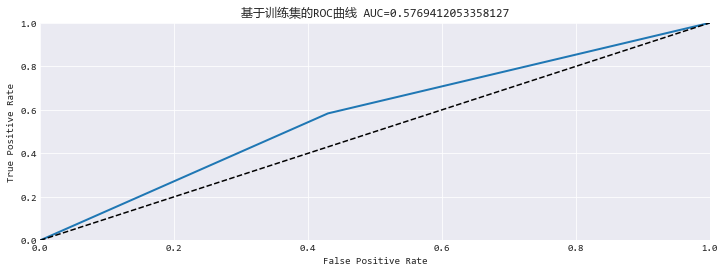

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
auc =  roc_auc_score(y_train, y_pred)
def plot_roc_curve(fpr, tpr, ds_type, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("基于{}的ROC曲线 AUC={}".format(ds_type, auc))
plot_roc_curve(fpr, tpr, "训练集")
plt.show()

## XGB调参-网格法

In [62]:
def modelfit(alg, X, y,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        # 注意这里的交叉验证是指在每次迭代时进行 比如nfold=5，则表示对每次迭代后的模型进行5折交叉验证
        # 如果early_stopping_rounds=5 表示如果连续5次迭代产生的在测试集上的交叉验证SCORE没有提高 则停止迭代
        # verbose_eval=True 表示显示中间迭代过程
        print("最佳迭代次数: {}\n".format(len(cvresult)),cvresult.iloc[-1, :])
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
    y_pred = alg.predict(X)
    y_prob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y.values, y_pred))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, y_prob))
                    
    feat_imp =  pd.Series(alg.feature_importances_, index=X.columns).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.savefig(r"E:\07_data\02_factor\feat_imp.png")

In [48]:
X_train = pd.read_csv(r"E:\07_data\02_factor\temp_data\X_train.csv", index_col=0)
y_train = pd.read_csv(r"E:\07_data\02_factor\temp_data\y_train.csv", index_col=0)

### 调参前的效果

[0]	train-auc:0.588311+0.00620494	test-auc:0.554113+0.0169625
[1]	train-auc:0.599141+0.00400033	test-auc:0.562025+0.0184051
[2]	train-auc:0.604321+0.00592154	test-auc:0.564173+0.0187565
[3]	train-auc:0.609368+0.00526083	test-auc:0.572386+0.0188838
[4]	train-auc:0.613235+0.00505403	test-auc:0.573396+0.0172894
[5]	train-auc:0.615834+0.00363949	test-auc:0.57442+0.0192196
[6]	train-auc:0.619247+0.00517304	test-auc:0.575569+0.0197733
[7]	train-auc:0.622692+0.00287274	test-auc:0.577618+0.0187532
[8]	train-auc:0.626292+0.00193216	test-auc:0.580971+0.0210927
[9]	train-auc:0.630996+0.00225654	test-auc:0.581686+0.0208824
[10]	train-auc:0.634978+0.00176029	test-auc:0.584241+0.0198159
[11]	train-auc:0.639241+0.00259874	test-auc:0.586665+0.0212443
[12]	train-auc:0.644482+0.00331209	test-auc:0.587785+0.0199841
[13]	train-auc:0.648933+0.00362267	test-auc:0.588289+0.019407
[14]	train-auc:0.651852+0.00374909	test-auc:0.588475+0.0198521
[15]	train-auc:0.655235+0.00349482	test-auc:0.589745+0.0180803
[16]

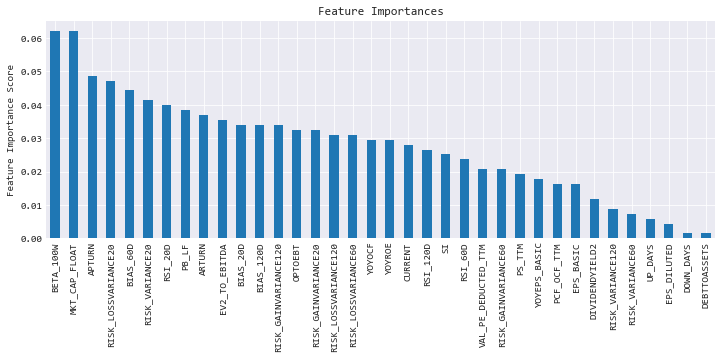

In [63]:
xgb_raw = XGBClassifier(seed=27)

# 如果改变modefit的参数值，必须重新定义模型
modelfit(xgb_raw, X=X_train, y=y_train)

In [200]:
# 确定最优基学习器个数
xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1, "eval_metric": "auc"}
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.33, random_state=seed)
dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 1000
bst = xgb.train(xgb_param, dtrain, num_round, watchlist, early_stopping_rounds=50, verbose_eval=False)
best_n_estimators = bst.best_ntree_limit
print("最优基学习器个数: ", best_n_estimators)
# y_pred_prob = bst.predict(dtest)
# labels = dtest.get_label()
# y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
# res2.append(roc_auc_score(labels, y_pred_prob))

最优基学习器个数:  216


In [201]:
best_n_estimators

216

In [206]:
# 调节树的深度
res1_1 = {}
for max_depth in range(1, 10, 1):
    res2_1 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": 0.2, "gamma": 0, "max_depth": max_depth, "min_child_weight": 1, "reg_alpha": 0, "reg_lambda": 1,
                "subsample": 0.8, "colsample_bytree": 0.8}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.33, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res2_1.append(metrics.roc_auc_score(labels, y_pred_prob))
    res1_1[max_depth] = np.mean(res2_1)
a = sorted(res1_1.items(),key=lambda x: x[1])[-1]
best_max_depth = a[0]
print("max_depth={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_max_depth, a[1]))

max_depth=8最优, 最优情况下在测试集的5次平均AUC为0.6513196788220876


In [207]:
# 调节min_child_weight
res2_1 = {}
for min_child_weight in range(1, 20, 4):
    res2_2 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": 0.2, "gamma": 0, "max_depth": best_max_depth, "min_child_weight": min_child_weight, "reg_alpha": 0, "reg_lambda": 1,
                "subsample": 0.8, "colsample_bytree": 0.8}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.33, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res2_2.append(metrics.roc_auc_score(labels, y_pred_prob))
    res2_1[max_depth] = np.mean(res2_2)
a = sorted(res2_1.items(),key=lambda x: x[1])[-1]
best_min_child_weight = a[0]
print("min_child_weight={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_min_child_weight, a[1]))

min_child_weight=9最优, 最优情况下在测试集的5次平均AUC为0.6525262443763827


In [218]:
# 调节gamma
res3_1 = {}
for gamma in np.arange(1, 20, 4):
    res3_2 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": 0.2, "gamma": gamma, "max_depth": best_max_depth, "min_child_weight": best_min_child_weight,
                "reg_alpha": 0, "reg_lambda": 1,
                "subsample": 0.8, "colsample_bytree": 0.8}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.33, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res3_2.append(metrics.roc_auc_score(labels, y_pred_prob))
    res3_1[gamma] = np.mean(res3_2)
a = sorted(res3_1.items(),key=lambda x: x[1])[-1]
best_gamma = a[0]
print("gamma={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_gamma, a[1]))

gamma=1最优, 最优情况下在测试集的5次平均AUC为0.6514044798537567


In [6]:
best_n_estimators = 216
best_max_depth = 8
best_min_child_weight=9
best_gamma = 1


In [8]:
# 调节subsample 
res4_1 = {}
for subsample in np.arange(0.85, 0.95, 0.01):
    res4_2 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": 0.2, "gamma": best_gamma, "max_depth": best_max_depth, "min_child_weight": best_min_child_weight,
                "reg_alpha": 0, "reg_lambda": 1,
                "subsample": subsample, "colsample_bytree": 0.8}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.33, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res4_2.append(metrics.roc_auc_score(labels, y_pred_prob))
    res4_1[subsample] = np.mean(res4_2)
a = sorted(res4_1.items(),key=lambda x: x[1])[-1]
best_subsample = a[0]
print("subsample={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_subsample, a[1]))

subsample=0.93最优, 最优情况下在测试集的5次平均AUC为0.6533398669508245


In [10]:
# 调节colsample_bytree
res5_1 = {}
for colsample_bytree in np.arange(0.9, 1.01, 0.01):
    res5_2 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": 0.2, "gamma": best_gamma, "max_depth": best_max_depth, "min_child_weight": best_min_child_weight,
                "reg_alpha": 0, "reg_lambda": 1,
                "subsample": best_subsample, "colsample_bytree": colsample_bytree}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.33, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res5_2.append(metrics.roc_auc_score(labels, y_pred_prob))
    res5_1[colsample_bytree] = np.mean(res5_2)
a = sorted(res5_1.items(),key=lambda x: x[1])[-1]
best_colsample_bytree = a[0]
print("colsample_bytree={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_colsample_bytree, a[1]))

colsample_bytree=0.9400000000000001最优, 最优情况下在测试集的5次平均AUC为0.6560411942824714


In [13]:
# 调节reg_alpha
res6_1 = {}
for reg_alpha in [0, 1e-5, 1e-2, 0.1, 1, 100]:
    res6_2 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": 0.2, "gamma": best_gamma, "max_depth": best_max_depth, "min_child_weight": best_min_child_weight,
                "reg_alpha": reg_alpha, "reg_lambda": 1,
                "subsample": best_subsample, "colsample_bytree": best_colsample_bytree}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.33, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res6_2.append(metrics.roc_auc_score(labels, y_pred_prob))
    res6_1[reg_alpha] = np.mean(res6_2)
a = sorted(res6_1.items(),key=lambda x: x[1])[-1]
best_reg_alpha = a[0]
print("reg_alpha={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_reg_alpha, a[1]))

reg_alpha=0.01最优, 最优情况下在测试集的5次平均AUC为0.6586566845685605


In [17]:
# 调节reg_lambda
res7_1 = {}
for reg_lambda in np.arange(85, 96, 1):
    res7_2 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": 0.2, "gamma": best_gamma, "max_depth": best_max_depth, "min_child_weight": best_min_child_weight,
                "reg_alpha": best_reg_alpha, "reg_lambda": reg_lambda,
                "subsample": best_subsample, "colsample_bytree": best_colsample_bytree}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.33, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res7_2.append(metrics.roc_auc_score(labels, y_pred_prob))
    res7_1[reg_lambda] = np.mean(res7_2)
a = sorted(res7_1.items(),key=lambda x: x[1])[-1]
best_reg_lambda = a[0]
print("reg_lambda={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_reg_lambda, a[1]))

reg_lambda=91最优, 最优情况下在测试集的5次平均AUC为0.6652163962417508


In [20]:
# 调节eta
res8_1 = {}
for eta in np.arange(0.01, 0.11, 0.01):
    res8_2 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": eta, "gamma": best_gamma, "max_depth": best_max_depth, "min_child_weight": best_min_child_weight,
                "reg_alpha": best_reg_alpha, "reg_lambda": best_reg_lambda,
                "subsample": best_subsample, "colsample_bytree": best_colsample_bytree}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.33, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res8_2.append(metrics.roc_auc_score(labels, y_pred_prob))
    res8_1[eta] = np.mean(res8_2)
a = sorted(res8_1.items(),key=lambda x: x[1])[-1]
best_eta = a[0]
print("eta={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_eta, a[1]))

eta=0.08最优, 最优情况下在测试集的5次平均AUC为0.6708974916306898


## XGB调参-GA法

In [45]:
import numpy as np
from scipy.optimize import fsolve, basinhopping
import random
import timeit


# 根据解的精度确定染色体(chromosome)的长度
# 需要根据决策变量的上下边界来确定
def getEncodedLength(delta=0.0001, boundarylist=[]):
    # 每个变量的编码长度
    lengths = []
    for i in boundarylist:
        lower = i[0]
        upper = i[1]
        # lamnda 代表匿名函数f(x)=0,50代表搜索的初始解
        res = fsolve(lambda x: ((upper - lower) * 1 / delta) - 2 ** x - 1, 50)
        length = int(np.floor(res[0]))
        lengths.append(length)
    return lengths
    pass


# 随机生成初始编码种群
def getIntialPopulation(encodelength, populationSize):
    # 随机化初始种群为0
    chromosomes = np.zeros((populationSize, sum(encodelength)), dtype=np.uint8)
    for i in range(populationSize):
        chromosomes[i, :] = np.random.randint(0, 2, sum(encodelength))
    # print('chromosomes shape:', chromosomes.shape)
    return chromosomes


# 染色体解码得到表现型的解
def decodedChromosome(encodelength, chromosomes, boundarylist, delta=0.0001):
    populations = chromosomes.shape[0]
    variables = len(encodelength)
    decodedvalues = np.zeros((populations, variables))
    for k, chromosome in enumerate(chromosomes):
        chromosome = chromosome.tolist()
        start = 0
        for index, length in enumerate(encodelength):
            # 将一个染色体进行拆分，得到染色体片段
            power = length - 1
            # 解码得到的10进制数字
            demical = 0
            for i in range(start, length + start):
                demical += chromosome[i] * (2 ** power)
                power -= 1
            lower = boundarylist[index][0]
            upper = boundarylist[index][1]
            decodedvalue = lower + demical * (upper - lower) / (2 ** length - 1)
            decodedvalues[k, index] = decodedvalue
            # 开始去下一段染色体的编码
            start = length
    return decodedvalues


# 得到个体的适应度值及每个个体被选择的累积概率
def getFitnessValue(func, chromosomesdecoded):
    # 得到种群规模和决策变量的个数
    population, nums = chromosomesdecoded.shape
    # 初始化种群的适应度值为0
    fitnessvalues = np.zeros((population, 1))
    # 计算适应度值
    for i in range(population):
        fitnessvalues[i, 0] = func(chromosomesdecoded[i, :])
    # 计算每个染色体被选择的概率
    probability = fitnessvalues / np.sum(fitnessvalues)
    # 得到每个染色体被选中的累积概率
    cum_probability = np.cumsum(probability)
    return fitnessvalues, cum_probability


# 新种群选择
def selectNewPopulation(chromosomes, cum_probability):
    m, n = chromosomes.shape
    newpopulation = np.zeros((m, n), dtype=np.uint8)
    # 随机产生M个概率值
    randoms = np.random.rand(m)
    for i, randoma in enumerate(randoms):
        logical = cum_probability >= randoma
        index = np.where(logical == 1)
        # index是tuple,tuple中元素是ndarray
        newpopulation[i, :] = chromosomes[index[0][0], :]
    return newpopulation
    pass


# 新种群交叉
def crossover(population, Pc=0.8):
    """
    :param population: 新种群
    :param Pc: 交叉概率默认是0.8
    :return: 交叉后得到的新种群
    """
    # 根据交叉概率计算需要进行交叉的个体个数
    m, n = population.shape
    numbers = np.uint8(m * Pc)
    # 确保进行交叉的染色体个数是偶数个
    if numbers % 2 != 0:
        numbers += 1
    # 交叉后得到的新种群
    updatepopulation = np.zeros((m, n), dtype=np.uint8)
    # 产生随机索引
    index = random.sample(range(m), numbers)
    # 不进行交叉的染色体进行复制
    for i in range(m):
        if not index.__contains__(i):
            updatepopulation[i, :] = population[i, :]
    # crossover
    while len(index) > 0:
        a = index.pop()
        b = index.pop()
        # 随机产生一个交叉点
        crossoverPoint = random.sample(range(1, n), 1)
        crossoverPoint = crossoverPoint[0]
        # one-single-point crossover
        updatepopulation[a, 0:crossoverPoint] = population[a, 0:crossoverPoint]
        updatepopulation[a, crossoverPoint:] = population[b, crossoverPoint:]
        updatepopulation[b, 0:crossoverPoint] = population[b, 0:crossoverPoint]
        updatepopulation[b, crossoverPoint:] = population[a, crossoverPoint:]
    return updatepopulation
    pass


# 染色体变异
def mutation(population, Pm=0.01):
    """
    :param population: 经交叉后得到的种群
    :param Pm: 变异概率默认是0.01
    :return: 经变异操作后的新种群
    """
    updatepopulation = np.copy(population)
    m, n = population.shape
    # 计算需要变异的基因个数
    gene_num = np.uint8(m * n * Pm)
    # 将所有的基因按照序号进行10进制编码，则共有m*n个基因
    # 随机抽取gene_num个基因进行基本位变异
    mutationGeneIndex = random.sample(range(0, m * n), gene_num)
    # 确定每个将要变异的基因在整个染色体中的基因座(即基因的具体位置)
    for gene in mutationGeneIndex:
        # 确定变异基因位于第几个染色体
        chromosomeIndex = gene // n
        # 确定变异基因位于当前染色体的第几个基因位
        geneIndex = gene % n
        # mutation
        if updatepopulation[chromosomeIndex, geneIndex] == 0:
            updatepopulation[chromosomeIndex, geneIndex] = 1
        else:
            updatepopulation[chromosomeIndex, geneIndex] = 0
    return updatepopulation
    pass


# 定义适应度函数
# def fitnessFunction():
#	return lambda x: 21.5 + x[0] * np.sin(4 * np.pi * x[0]) + x[1] * np.sin(20 * np.pi * x[1])
#	pass
def get_cv_score(params, X, y, nfolds, test_size=0.33):
    res = []
    for seed in np.random.randint(1, 100, nfolds):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                     "max_depth": 8, "min_child_weight": 9,
                     "gamma": params[0], "subsample": params[1], "colsample_bytree": params[2],
                     "reg_alpha": params[3], "reg_lambda": params[4], "eta": params[5]}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X, y, test_size=test_size, random_state=seed)
        dtrain = xgb.DMatrix(X_train1.values, label=y_train1.values)
        dtest = xgb.DMatrix(X_train2.values, label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, 216, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res.append(metrics.roc_auc_score(labels, y_pred_prob))
    return np.mean(res)


def fitnessFunction(x):
    return get_cv_score(params=x, X=X_train, y=y_train, nfolds=1)


def main(max_iter=500):
    # 每次迭代得到的最优解
    optimalSolutions = []
    optimalValues = []
    # 决策变量的取值范围
    decisionVariables = [[0, 2], [0.8, 1], [0.8, 1], [0, 0.1], [85, 300], [0, 0.2]]
    # 得到染色体编码长度
    lengthEncode = getEncodedLength(boundarylist=decisionVariables)
    for iteration in range(max_iter):
        print(iteration)
        # 得到初始种群编码
        chromosomesEncoded = getIntialPopulation(lengthEncode, 5)
        # 种群解码
        decoded = decodedChromosome(lengthEncode, chromosomesEncoded, decisionVariables)
        # 得到个体适应度值和个体的累积概率
        evalvalues, cum_proba = getFitnessValue(fitnessFunction, decoded)
        print("当前种群最好效果：AUC={}".format(evalvalues.max()))
        # 选择新的种群
        newpopulations = selectNewPopulation(chromosomesEncoded, cum_proba)
        # 进行交叉操作
        crossoverpopulation = crossover(newpopulations)
        # mutation
        mutationpopulation = mutation(crossoverpopulation)
        # 将变异后的种群解码，得到每轮迭代最终的种群
        final_decoded = decodedChromosome(lengthEncode, mutationpopulation, decisionVariables)
        
        # 适应度评价
        fitnessvalues, cum_individual_proba = getFitnessValue(fitnessFunction, final_decoded)
        # 搜索每次迭代的最优解，以及最优解对应的目标函数的取值
        optimalValues.append(np.max(list(fitnessvalues)))
        index = np.where(fitnessvalues == max(list(fitnessvalues)))
        optimalSolutions.append(final_decoded[index[0][0], :])
    # 搜索最优解
    optimalValue = np.max(optimalValues)
    optimalIndex = np.where(optimalValues == optimalValue)
    optimalSolution = optimalSolutions[optimalIndex[0][0]]
    return optimalSolution, optimalValue

In [47]:
solution, value = main(max_iter=50)
print('最优解: gamma, subsample, colsample_bytree, reg_alpha, reg_lambda, learning_rate')
print(solution[0], solution[1], solution[2], solution[3], solution[4], solution[5])
print('最优目标函数值:', value)
# # 测量运行时间
# elapsedtime = timeit.timeit(stmt=main, number=1)
# print('Searching Time Elapsed:(S)', elapsedtime)


0
当前种群最好效果：AUC=0.6693693790409246
1
当前种群最好效果：AUC=0.665439236351202
2
当前种群最好效果：AUC=0.6678502867063122
3
当前种群最好效果：AUC=0.6646521548631874
4
当前种群最好效果：AUC=0.666125331368344
5
当前种群最好效果：AUC=0.6675462664914632
6
当前种群最好效果：AUC=0.6718757223715581
7
当前种群最好效果：AUC=0.6693958735223648
8
当前种群最好效果：AUC=0.6642560671705839
9
当前种群最好效果：AUC=0.6652460916440568
10
当前种群最好效果：AUC=0.6679782406715025
11
当前种群最好效果：AUC=0.666424362606856
12
当前种群最好效果：AUC=0.6737376697951003
13
当前种群最好效果：AUC=0.6630865849951428
14
当前种群最好效果：AUC=0.6660181361880971
15
当前种群最好效果：AUC=0.678062119331951
16
当前种群最好效果：AUC=0.6684596043138035
17
当前种群最好效果：AUC=0.6689379206191579
18
当前种群最好效果：AUC=0.6666762982874428
19
当前种群最好效果：AUC=0.6668573835187377
20
当前种群最好效果：AUC=0.6731358087308903
21
当前种群最好效果：AUC=0.6630016174468749
22
当前种群最好效果：AUC=0.678456726767479
23
当前种群最好效果：AUC=0.6647374952598066
24
当前种群最好效果：AUC=0.6653648165485353
25
当前种群最好效果：AUC=0.6754206937639307
26
当前种群最好效果：AUC=0.668806776992336
27
当前种群最好效果：AUC=0.6681506420493064
28
当前种群最好效果：AUC=0.6643082876269812
2

In [179]:
xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
             "max_depth": 8, "min_child_weight": 9,
             "gamma": 0.345724226332, "subsample": 0.91788856305, "colsample_bytree": 0.807233626588,
             "reg_alpha": 0.00352250489237, "reg_lambda": 196.462040645, "eta": 0.0961876832845}
dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
bst = xgb.train(xgb_param, dtrain, 216, verbose_eval=False)

In [52]:
bst.save_model(r"E:\07_data\02_factor\temp_data\xgb_model_final.model")

In [67]:
bst = xgb.Booster({'nthread': 4}) 
bst.load_model(r"E:\07_data\02_factor\temp_data\xgb_model_final.model")

In [192]:
xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
             "subsample": 0.4, "colsample_bytree": 0.4,
             "reg_alpha": 100, "reg_lambda": 2000}
dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
bst = xgb.train(xgb_param, dtrain, 216, verbose_eval=False)

In [28]:
y_pred_prob = bst.predict(dtrain)

# 模型测试
- 查准率=0.5并不等价于随机猜测 假设一共有N只股票 从中抽取n只，有k只强势股
- 查准率等于0.5 意味着选出的n只股票中 有n/2只是强势股票 
- 在随机猜测情况下，任取一只股票，要么为强势股 要么为弱势股 猜对的概率为0.5，则n次猜测猜对的次数服从二项分布B(n,0.5) 可知当n足够大时，猜对次数大于等于一半的概率接近0.5

## 测试集预处理

In [15]:
df_test= pd.read_csv(r"E:\07_data\02_factor\temp_data\df_test.csv", index_col=0)
f = open(r"E:\07_data\02_factor\temp_data\std_info.txt", 'rb')  
std_info=pickle.load(f)  

In [16]:
df_test = df_test.set_index(['sec_id', 'date'])
droplist = ['yearmonth', 'group_id', 'date_available']
df_test = df_test.drop(droplist, axis=1)
df_test.iloc[:,:-1] = (df_test.iloc[:,:-1] - std_info['mean']) / std_info['std']
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1].to_frame()

In [14]:
X_train = pd.read_csv(r"E:\07_data\02_factor\temp_data\X_train.csv", index_col=0)
y_train = pd.read_csv(r"E:\07_data\02_factor\temp_data\y_train.csv", index_col=0, header=None)

## 统计指标

### 导入模型

In [17]:
# bst = xgb.Booster({'nthread': 4}) 
# bst.load_model(r"E:\07_data\02_factor\temp_data\xgb_model_raw.model")
dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dtest = xgb.DMatrix(X_test.values, label=y_test.values)

### P-R曲线确定决策阈值

In [20]:
from sklearn.metrics import precision_score, recall_score
y_scores = bst.predict(X_train)
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'feature_names'

In [27]:
y_scores = bst.predict(dtrain)

In [107]:
# 根据业务要求确定最佳决策阈值
ix, iv = False, False
for i, v in enumerate(precisions):
    if v > 0.7:
        if not ix:
            ix = i
            iv = v
        elif v < iv:
            ix = i
            iv = v
best_threshold = thresholds[ix]
print("Best threshold=", best_threshold)
print("最佳阈值下的precision={} recall={}".format(precisions[ix], recalls[ix]))

Best threshold= 0.455054
最佳阈值下的precision=0.7000446030330062 recall=0.8695290858725762


In [24]:
bst.predict(dtest)

array([ 0.53049797,  0.61175174,  0.39847749, ...,  0.27546948,
        0.50048935,  0.3792246 ], dtype=float32)

In [25]:
# 测试集上的表现

y_test_scores = bst.predict(dtest)
y_test_pred = (y_test_scores > 0.6)
# print("Precision=", precision_score(y_true=y_test, y_pred=y_test_pred), "\n", "\bRecall=", recall_score(y_true=y_test, y_pred=y_test_pred))  

### ROC曲线

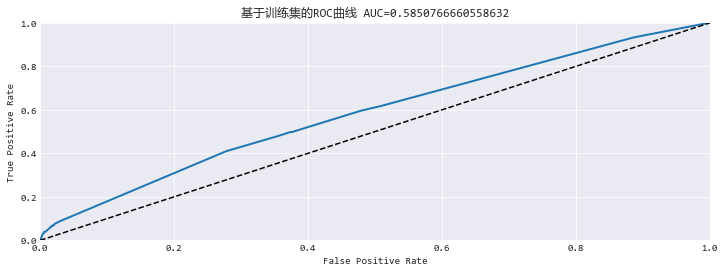

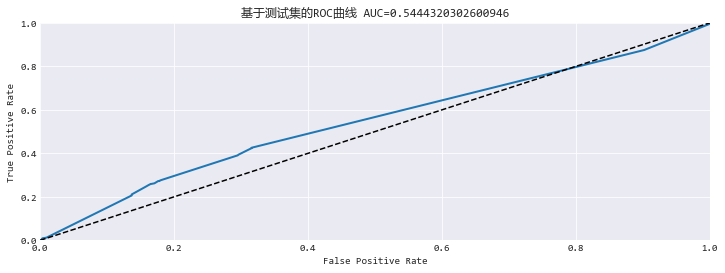

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
y_scores = bst.predict(dtrain)
y_test_scores = bst.predict(dtest)
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
auc =  roc_auc_score(y_train, y_scores)
def plot_roc_curve(fpr, tpr, ds_type, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("基于{}的ROC曲线 AUC={}".format(ds_type, auc))
plot_roc_curve(fpr, tpr, "训练集")
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
auc =  roc_auc_score(y_test, y_test_scores)
plot_roc_curve(fpr, tpr, "测试集")
plt.show()


### 历史数据回测

In [127]:
df_raw = pd.read_csv(r"E:\07_data\02_factor\temp_data\df_train_plan4.csv", index_col=0)
def drop_overmissing_feats(dsi, threshold):
    """
    删除缺失过多的特征  然后剔除有缺失值的样本
    """
    a = dsi.isnull().sum() / len(dsi) < threshold
    feats_to_retain = a[a].index
    dsi = dsi[feats_to_retain].dropna()
    dsi = dsi.reset_index()
    del dsi['index']
    return dsi
    # del df_raw['sec_id']
    # del train['group_id']
df_raw = drop_overmissing_feats(df_raw, 0.1)

In [128]:
back_test_period = fk.get_monthly_last_trading_days(start="2014-08-01", end="2016-12-31")
df_backtest = df_raw[df_raw.date.isin(back_test_period)].copy()
df_backtest1 = preprocessing(dsi=df_backtest, lp=0.05, up=0.95, label_kind="B")
df_backtest2 = df_backtest1.set_index(['sec_id', 'date'])
droplist = ['yearmonth', 'group_id', 'date_available']
df_backtest3 = df_backtest2.drop(droplist, axis=1)
df_backtest3.iloc[:,:-1] = (df_backtest3.iloc[:,:-1] - df_backtest3.iloc[:,:-1].mean()) / df_backtest3.iloc[:,:-1].std()
X_backtest = df_backtest3.iloc[:,:-1]
y_backtest = df_backtest3.iloc[:,-1].to_frame()

删除前样本个数: 8319
删除后样本个数: 7445


In [129]:
X_backtest = X_backtest.sort_index(level="sec_id")
y_backtest = y_backtest.sort_index(level="sec_id")
close = factor.get_secs_index(index="close", trading_days=df_raw.date.tolist(), sec_ids=df_raw.sec_id.tolist())
df_raw = df_raw.merge(close, how='inner', on=['date', 'sec_id'])
return_lib = df_raw.set_index(['sec_id', 'date'])
return_lib = return_lib.sort_index(level='sec_id')

In [130]:
def derive_next_month_rr(sec_ids):
    """
    获取给定股票列表在给定日期列表的下个月收益率
    @sec_ids <list>: 股票列表
    """
    # 取月初月末的交易日列表
    tds = pd.read_csv(r"E:\07_data\02_factor\temp_data\trading_days.csv")
    tds['group'] = tds['date'].apply(lambda x: x[:7])
    tds = tds.sort_values(['date'])
    first = tds.groupby('group').head(1)
    last = tds.groupby('group').tail(1)
    tds=first.append(last)
    tds = tds.sort_values('date')

    # 获取月初月末交易日的收盘价
    close = factor.get_secs_index(index="close", trading_days=tds.date.tolist(), sec_ids=sec_ids)
    close = close.sort_values(['sec_id', 'date'])
    close['yearmonth'] = close['date'].apply(lambda x: x[:7])

    # 获取月收益率
    def cal_ret(x):
        close_id = x.columns.tolist().index('close')
        return x.iloc[-1, close_id]/x.iloc[0, close_id] - 1
    df_target=close.groupby(['sec_id', 'yearmonth'], as_index=False).apply(lambda x: cal_ret(x))
    df_target=df_target.reset_index().rename(columns={0: 'month_ret'})
    return df_target


In [134]:
NUM = 10
records = {}
for date in list(X_backtest.index.levels[1]):
    # 根据当前日期(月末)的特征计算选中的股票
    X_now =X_backtest.loc[(slice(None), date),:].copy()
    d_now = xgb.DMatrix(X_now.values)
    X_now['prob'] = bst.predict(d_now)
    X_now = X_now.sort_values(['prob'])
    selected = X_now.iloc[-NUM:, -1].reset_index()['sec_id'].tolist()
    # 获得入选股票在下个月的收益率
    print(selected)
    perform = return_lib.loc[(selected, date), ['close', 'month_ret']]
    print(perform)
    records[date] = (perform['close'] * perform['month_ret']).sum() / perform['close'].sum()
    
df_records = pd.DataFrame([[i, v] for i,v in records.items()], columns=['date', 'month_ret'])
df_records['yearmonth'] = df_records['date'].apply(lambda x: dk.date2char(dk.char2datetime(x) +  dk.timedelta({'months': 1}))[:7])
df_records = df_records.rename(columns={'month_ret': 'model_ret'})

['000848.SZ', '000887.SZ', '600572.SH', '002004.SZ', '300274.SZ', '600060.SH', '600655.SH', '600183.SH', '002275.SZ', '600522.SH']
                      close  month_ret
sec_id    date                        
000848.SZ 2014-08-29  10.76  -0.013941
000887.SZ 2014-08-29  11.00   0.201432
002004.SZ 2014-08-29   7.48  -0.029333
002275.SZ 2014-08-29  15.85   0.141433
300274.SZ 2014-08-29   9.86   0.091734
600060.SH 2014-08-29   9.34   0.160127
600183.SH 2014-08-29   6.64   0.062969
600522.SH 2014-08-29   5.57   0.102609
600572.SH 2014-08-29   6.22   0.015823
600655.SH 2014-08-29   7.60   0.169069
['000661.SZ', '002275.SZ', '002179.SZ', '002267.SZ', '002250.SZ', '600436.SH', '600511.SH', '600219.SH', '000062.SZ', '002004.SZ']
                      close  month_ret
sec_id    date                        
000062.SZ 2014-09-30  16.64  -0.044944
000661.SZ 2014-09-30  87.63  -0.041341
002004.SZ 2014-09-30   7.28   0.029024
002179.SZ 2014-09-30  15.13   0.050657
002250.SZ 2014-09-30  15.46  -0.0842

                      close  month_ret
sec_id    date                        
000600.SZ 2016-04-29   9.00  -0.028571
002019.SZ 2016-04-29  16.71  -0.045824
002174.SZ 2016-04-29  33.51  -0.099596
002517.SZ 2016-04-29  18.86  -0.004126
300122.SZ 2016-04-29  13.39  -0.055935
600026.SH 2016-04-29   6.12  -0.049442
600085.SH 2016-04-29  27.46  -0.046111
600654.SH 2016-04-29  22.60   0.000000
601000.SH 2016-04-29   4.15  -0.087059
601801.SH 2016-04-29  10.76   0.033015
['600085.SH', '000539.SZ', '002563.SZ', '600583.SH', '002050.SZ', '002493.SZ', '002008.SZ', '601880.SH', '600219.SH', '000600.SZ']
                      close  month_ret
sec_id    date                        
000539.SZ 2016-05-31   4.96  -0.006024
000600.SZ 2016-05-31   8.84  -0.039638
002008.SZ 2016-05-31  22.86  -0.011324
002050.SZ 2016-05-31   8.94   0.037486
002493.SZ 2016-05-31   8.05  -0.009889
002563.SZ 2016-05-31  10.61  -0.009515
600085.SH 2016-05-31  27.10   0.091484
600219.SH 2016-05-31   2.69   0.032258
600583.SH 2

In [135]:
# 获取基准收益
hs300_rr = derive_next_month_rr(['000300.SH'])
hs300_rr = hs300_rr.rename(columns={'month_ret': 'hs300_rr'})
del hs300_rr['sec_id']
df_records = df_records.merge(hs300_rr, how='left', on=['yearmonth'])

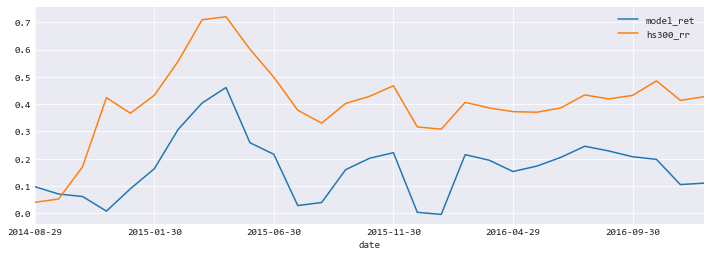

In [136]:
df_records.set_index('date').cumsum().plot()

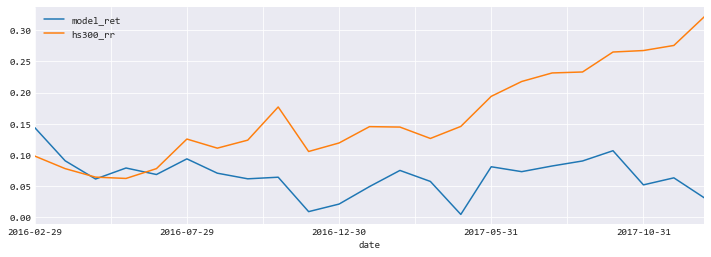

In [244]:
df_records.set_index('date').cumsum().plot()

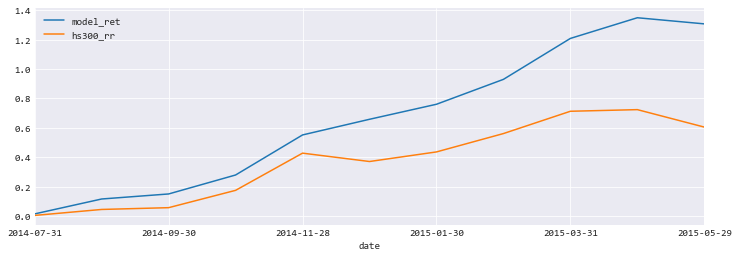

In [174]:
df_records.set_index('date').cumsum().plot()

In [351]:
df_records['yearmonth'] = df_records['date'].apply(lambda x: dk.date2char(dk.char2datetime(x) +  dk.timedelta({'months': 1}))[:7])

In [358]:
df_records.merge(hs300_rr, how='left', on=['yearmonth'])

,date,month_ret,yearmonth,hs300_rr
0,2014-01-30,-0.044911,2014-02,-0.015147
1,2014-02-28,-0.070724,2014-03,-0.020118
2,2014-03-31,-0.045971,2014-04,-0.002060
3,2014-04-30,0.014398,2014-05,-0.000003
4,2014-05-30,0.045080,2014-06,0.007070
5,2014-06-30,0.122096,2014-07,0.085787
6,2014-07-31,0.049671,2014-08,0.003814
7,2014-08-29,0.081051,2014-09,0.040619
8,2014-09-30,-0.028444,2014-10,0.012081
9,2014-10-31,0.094628,2014-11,0.117917


# 单因子有效性检验

In [129]:
schema = pd.DataFrame(DataAPI.schema.get_schema("indicator")).T
inds_ts = schema[schema.type == '时间序列'].index.tolist()
inds_fr = schema[schema.type == '财报数据'].index.tolist()
trading_days_ts = fk.get_monthly_last_trading_days(start="2006-01-01", end="2014-07-30")
# 流通市值介于LP与UP之间
LP = 0
UP = 1
NEW_CP = 400 # 小于此值为次新股
def dict2df(ind, trading_days):
    df_ind = DataAPI.read.get_secs_indicator_on_multidays(indicator=ind, trading_days=trading_days)
    output = pd.DataFrame()
    for date in df_ind:
        df = df_ind[date]
        df['date'] = date
        output = output.append(df)
    return output
mkt_cap_float = dict2df('MKT_CAP_FLOAT', trading_days_ts)
ipo_listdays = dict2df('IPO_LISTDAYS', trading_days_ts)
low = dict2df('LOW', trading_days_ts)
high = dict2df('HIGH', trading_days_ts)
pe = dict2df('VAL_PE_DEDUCTED_TTM', trading_days_ts)

df_sec_ids = mkt_cap_float.merge(ipo_listdays, how='inner', on=['sec_id', 'date'])
df_sec_ids = df_sec_ids.merge(low, how='inner', on=['sec_id', 'date'])
df_sec_ids = df_sec_ids.merge(high, how='inner', on=['sec_id', 'date'])
df_sec_ids = df_sec_ids.merge(pe, how='inner', on=['sec_id', 'date'])

df_sec_ids = df_sec_ids[df_sec_ids.VAL_PE_DEDUCTED_TTM > 0] # 剔除亏损股票
df_sec_ids = df_sec_ids[df_sec_ids.HIGH != df_sec_ids.LOW] # 剔除停牌股
df_sec_ids = df_sec_ids[df_sec_ids.IPO_LISTDAYS >= NEW_CP] # 剔除次新股

a=df_sec_ids.groupby(['date']).MKT_CAP_FLOAT.quantile(LP).to_frame().reset_index().rename(columns={'MKT_CAP_FLOAT': "size_LP"})
df_sec_ids = df_sec_ids.merge(a, how='inner', on=['date'])
a=df_sec_ids.groupby(['date']).MKT_CAP_FLOAT.quantile(UP).to_frame().reset_index().rename(columns={'MKT_CAP_FLOAT': "size_UP"})
df_sec_ids = df_sec_ids.merge(a, how='inner', on=['date'])

df_sec_ids = df_sec_ids[df_sec_ids.MKT_CAP_FLOAT.between(df_sec_ids['size_LP'], df_sec_ids['size_UP'])]

sec_ids = {}
date_list = list(set(df_sec_ids['date']))
for date in date_list:
    sec_ids[date] = list(df_sec_ids[df_sec_ids['date'] == date]['sec_id'])

In [131]:
# 1. 特征
schema = pd.DataFrame(DataAPI.schema.get_schema("indicator")).T
schema = schema[~schema.aspect.isin(['辅助指标', '价量指标'])]
inds_ts = schema[schema.type == '时间序列'].index.tolist()
# 这几个特征暂时没取完 为了避免下面的读写错误 先删除这个变量
# inds_ts.remove('RSI_60D')
# inds_ts.remove('RSI_120D')
# inds_ts.remove('RSI_20D')
inds_ts.remove('SHIBOR1W')
inds_ts.remove('TECH_CRY')
inds_ts.remove('TECH_MAWVAD')
inds_ts.remove('TECH_PSY')
inds_ts.remove('TECH_REVS10')
inds_ts.remove('TECH_REVS120')
inds_ts.remove('TECH_REVS20INDU1')
inds_ts.remove('TECH_REVS250')
inds_ts.remove('TECH_REVS5')
inds_ts.remove('TECH_REVS5INDU1')
inds_ts.remove('TECH_REVS60')
inds_ts.remove('TECH_REVS750')
inds_ts.remove('TECH_TURNOVERRATE10')
inds_ts.remove('TECH_TURNOVERRATE120')
inds_ts.remove('TECH_TURNOVERRATE20')
inds_ts.remove('TECH_TURNOVERRATE240')
inds_ts.remove('TECH_TURNOVERRATE5')
inds_ts.remove("TECH_TURNOVERRATE60")
inds_fr = schema[schema.type == '财报数据'].index.tolist()
# 时间序列指标
df_inds=pd.DataFrame()
for ind in inds_ts:
    df_ind = pd.DataFrame()
    for date in trading_days_ts:   
        a = DataAPI.read.get_secs_indicator(indicator=ind, sec_ids=sec_ids[date], date=date).reset_index()
        a['date'] = date
        df_ind = df_ind.append(a)
    if len(df_inds) == 0:
        df_inds = df_ind.copy()
    else:
        df_inds = df_inds.merge(df_ind, how='outer', on=['sec_id', 'date'])
        
df_inds['date_available'] = df_inds['date'].apply(lambda x: dk.get_available_report_day(x))

# 财务报表指标
report_days_to_load = list(set(df_inds['date_available']))
secs_list_temp = list(set(df_inds['sec_id']))  # 由于财报数据取报告日 为了保证所有需要股票都取到 取时间序列指标各月末入选股票的并集
df_frs=pd.DataFrame()
for ind in inds_fr:
    df_fr = pd.DataFrame()
    for date in report_days_to_load:
        a = DataAPI.read.get_secs_indicator(indicator=ind, sec_ids=secs_list_temp, date=date).reset_index()
        a['date'] = date
        df_fr = df_fr.append(a)
    if len(df_frs) == 0:
        df_frs = df_fr.copy()
    else:
        df_frs = df_frs.merge(df_fr, how='outer', on=['sec_id', 'date'])
df_frs = df_frs.rename(columns={'date': 'date_available'})
df_inds = df_inds.merge(df_frs, how='left', on=['sec_id', 'date_available'])
df_inds['yearmonth'] = df_inds['date'].apply(lambda x: dk.date2char(dk.char2datetime(x) +  dk.timedelta({'months': 1}))[:7])
def derive_next_month_rr(sec_ids):
    """
    获取给定股票列表在给定日期列表的下个月收益率
    @sec_ids <list>: 股票列表
    """
    # 取月初月末的交易日列表
    tds = pd.read_csv(r"E:\07_data\02_factor\temp_data\trading_days.csv")
    tds['group'] = tds['date'].apply(lambda x: x[:7])
    tds = tds.sort_values(['date'])
    first = tds.groupby('group').head(1)
    last = tds.groupby('group').tail(1)
    tds=first.append(last)
    tds = tds.sort_values('date')

    # 获取月初月末交易日的收盘价
    close = factor.get_secs_index(index="close", trading_days=tds.date.tolist(), sec_ids=sec_ids)
    close = close.sort_values(['sec_id', 'date'])
    close['yearmonth'] = close['date'].apply(lambda x: x[:7])

    # 获取月收益率
    def cal_ret(x):
        close_id = x.columns.tolist().index('close')
        return x.iloc[-1, close_id]/x.iloc[0, close_id] - 1
    df_target=close.groupby(['sec_id', 'yearmonth'], as_index=False).apply(lambda x: cal_ret(x))
    df_target=df_target.reset_index().rename(columns={0: 'month_ret'})
    return df_target

df_target = derive_next_month_rr(list(set(df_inds['sec_id'])))

df_raw=df_inds.merge(df_target, how='inner', on=['sec_id', 'yearmonth'])

In [132]:
df_raw.to_csv((r"E:\07_data\02_factor\temp_data\factor_test.csv"))

In [133]:
df_raw = pd.read_csv(r"E:\07_data\02_factor\temp_data\factor_test.csv", index_col=0)
df_raw['date_num'] = pd.to_datetime(df_raw['date'])

In [134]:
feats = list(df_raw.columns[1:-3])
feats.remove('date')
feats.remove('date_available')

In [135]:
from scipy import stats

BETA_100W
plot is saved to: E:\07_data\02_factor\plot\BETA_100W.png
BIAS_120D
plot is saved to: E:\07_data\02_factor\plot\BIAS_120D.png
BIAS_20D
plot is saved to: E:\07_data\02_factor\plot\BIAS_20D.png
BIAS_60D
plot is saved to: E:\07_data\02_factor\plot\BIAS_60D.png
DIVIDENDYIELD2
plot is saved to: E:\07_data\02_factor\plot\DIVIDENDYIELD2.png
DOWN_DAYS
plot is saved to: E:\07_data\02_factor\plot\DOWN_DAYS.png
DR001
plot is saved to: E:\07_data\02_factor\plot\DR001.png
DR007
plot is saved to: E:\07_data\02_factor\plot\DR007.png
EV2_TO_EBITDA
plot is saved to: E:\07_data\02_factor\plot\EV2_TO_EBITDA.png
LPR1Y
plot is saved to: E:\07_data\02_factor\plot\LPR1Y.png
MKT_CAP_FLOAT
plot is saved to: E:\07_data\02_factor\plot\MKT_CAP_FLOAT.png
PB_LF
plot is saved to: E:\07_data\02_factor\plot\PB_LF.png
PCF_OCF_TTM
plot is saved to: E:\07_data\02_factor\plot\PCF_OCF_TTM.png
PS_TTM
plot is saved to: E:\07_data\02_factor\plot\PS_TTM.png
RISK_GAINVARIANCE120
plot is saved to: E:\07_data\02_factor\

E:\06_software\Anoconda\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


plot is saved to: E:\07_data\02_factor\plot\RISK_VARIANCE120.png
RISK_VARIANCE20
plot is saved to: E:\07_data\02_factor\plot\RISK_VARIANCE20.png
RISK_VARIANCE60
plot is saved to: E:\07_data\02_factor\plot\RISK_VARIANCE60.png
RSI_120D
plot is saved to: E:\07_data\02_factor\plot\RSI_120D.png
RSI_20D
plot is saved to: E:\07_data\02_factor\plot\RSI_20D.png
RSI_60D
plot is saved to: E:\07_data\02_factor\plot\RSI_60D.png
SHIBORON
plot is saved to: E:\07_data\02_factor\plot\SHIBORON.png
SI
plot is saved to: E:\07_data\02_factor\plot\SI.png
TB10Y
plot is saved to: E:\07_data\02_factor\plot\TB10Y.png
TB1Y
plot is saved to: E:\07_data\02_factor\plot\TB1Y.png
TB5Y
plot is saved to: E:\07_data\02_factor\plot\TB5Y.png
UP_DAYS
plot is saved to: E:\07_data\02_factor\plot\UP_DAYS.png
USDCNY
plot is saved to: E:\07_data\02_factor\plot\USDCNY.png
USDX
plot is saved to: E:\07_data\02_factor\plot\USDX.png
VAL_PE_DEDUCTED_TTM
plot is saved to: E:\07_data\02_factor\plot\VAL_PE_DEDUCTED_TTM.png
WEST_AVGNP_YO

AttributeError: 'DataFrame' object has no attribute 'to_frame'

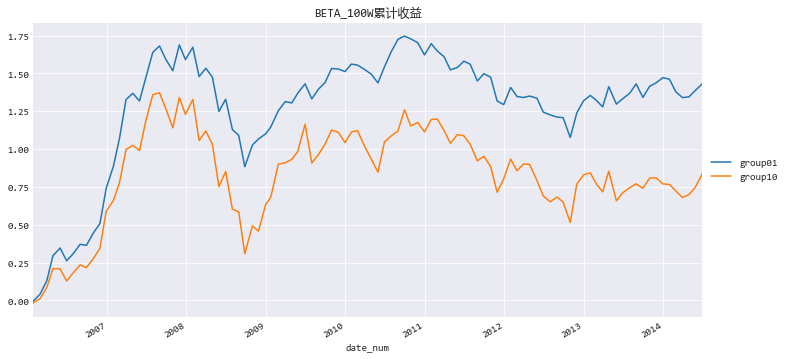

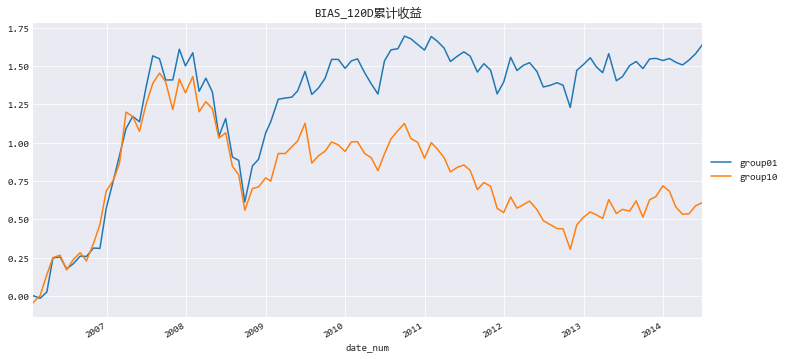

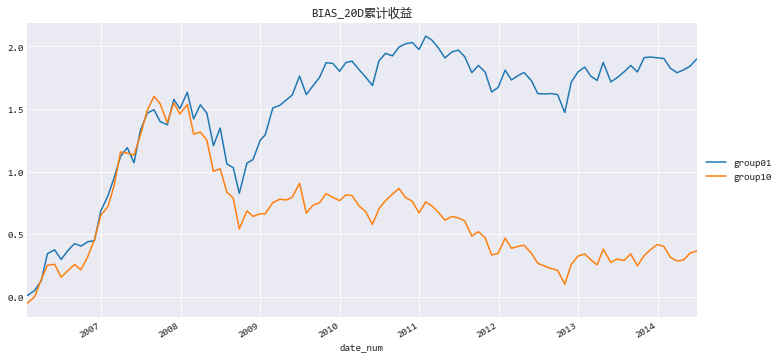

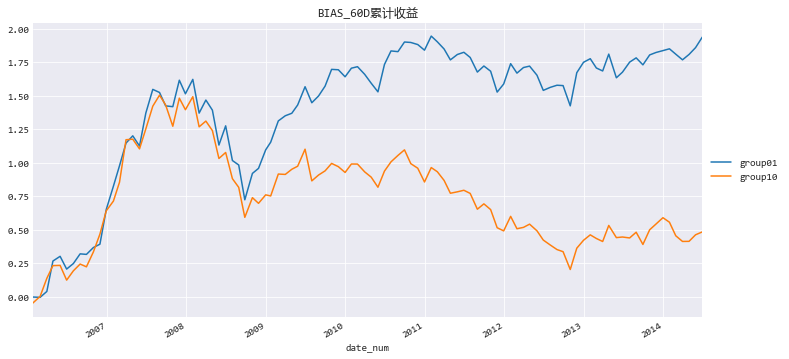

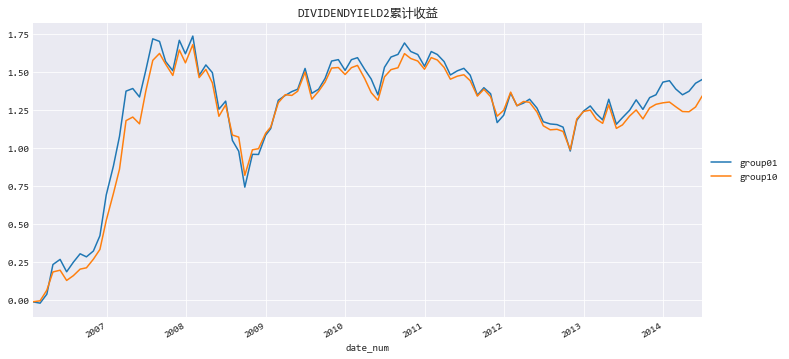

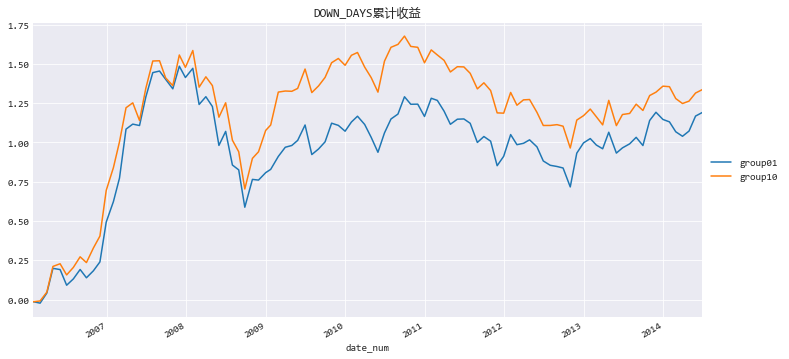

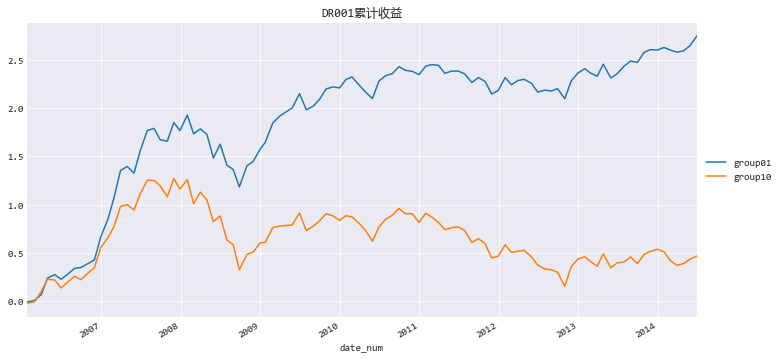

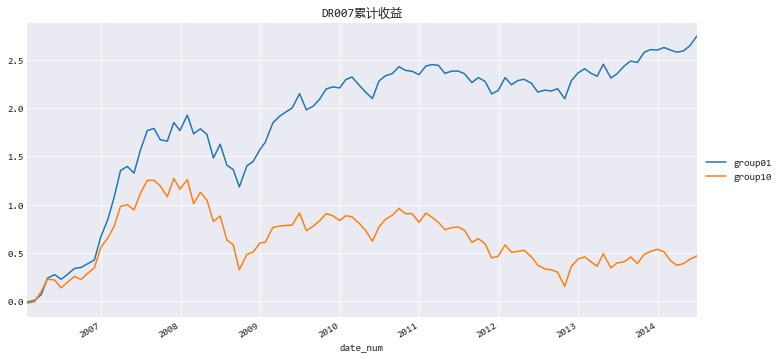

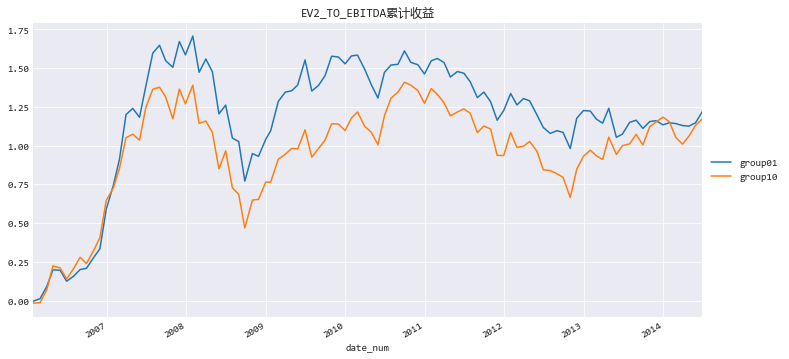

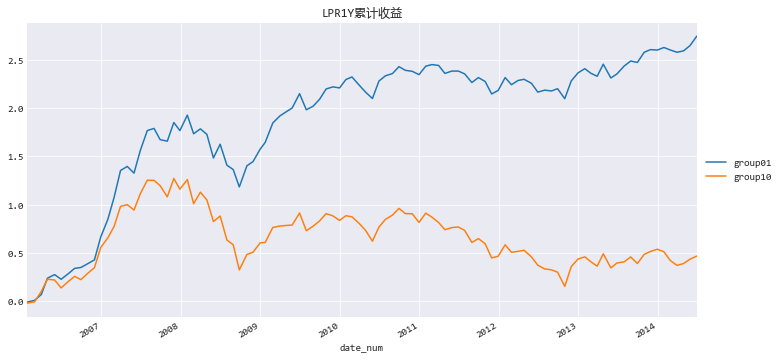

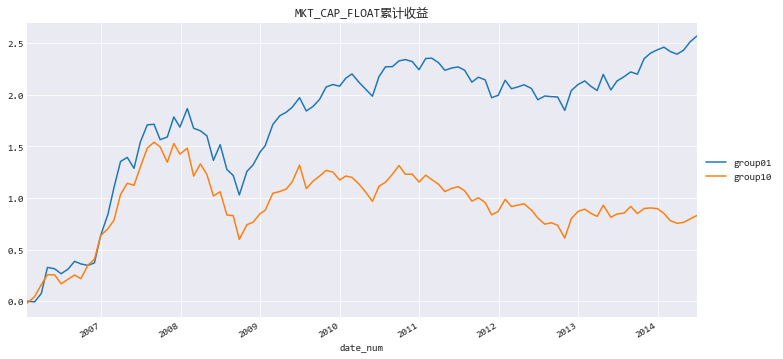

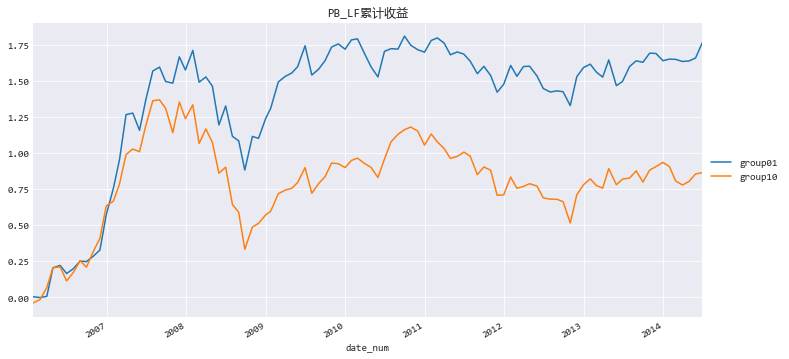

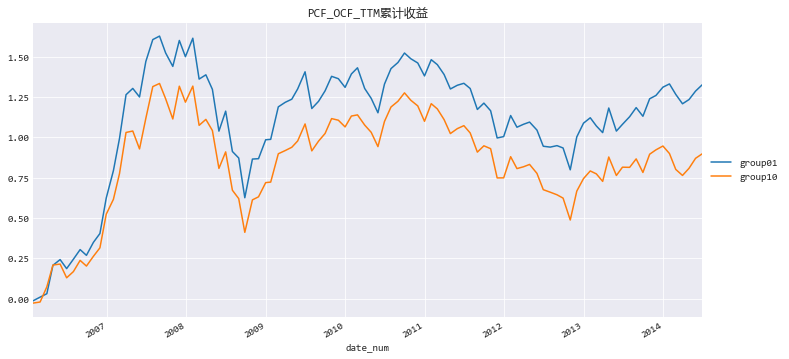

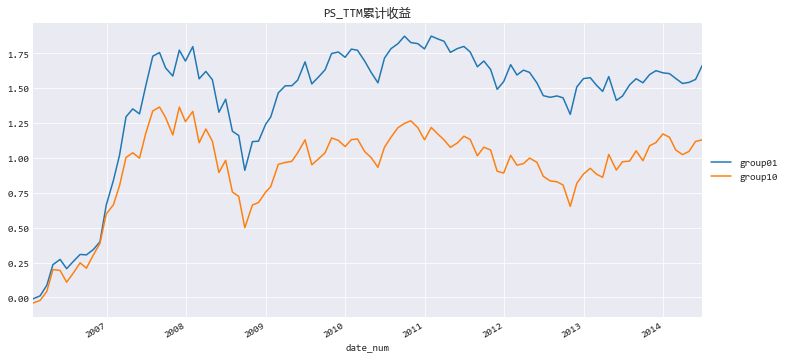

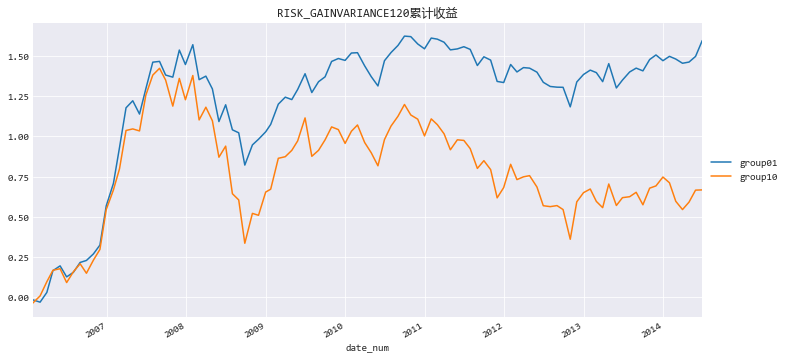

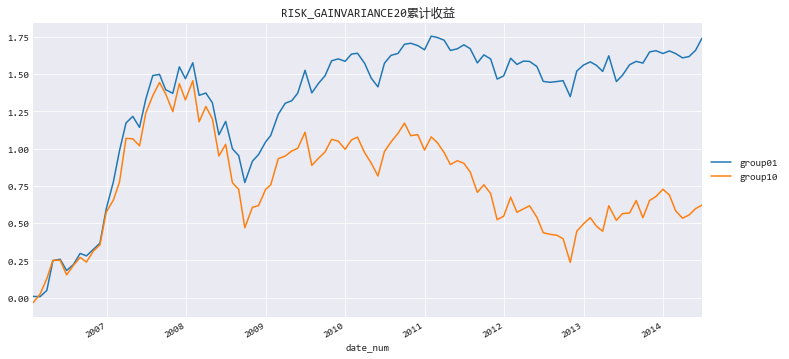

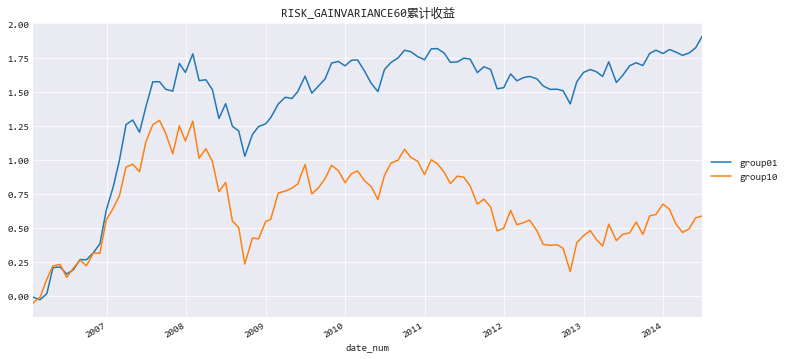

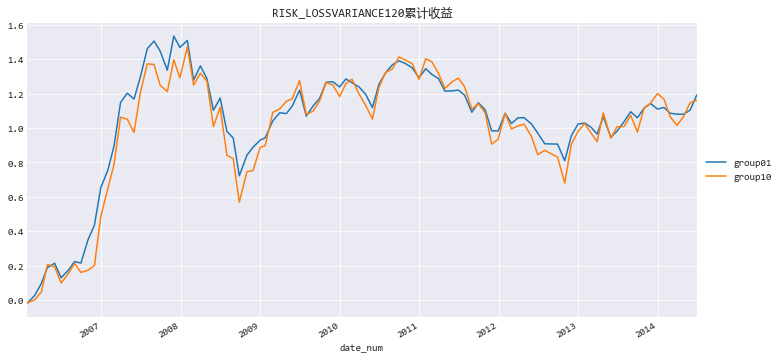

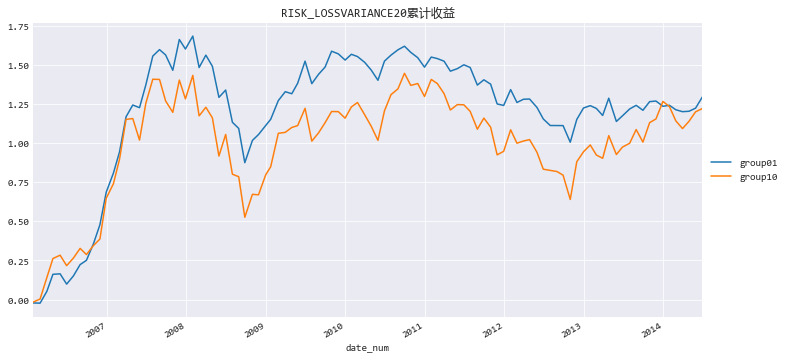

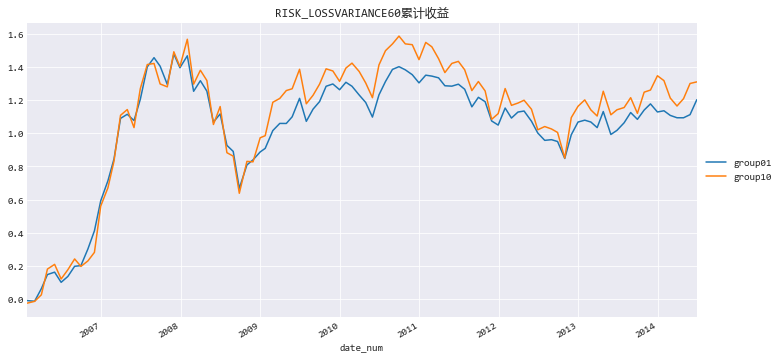

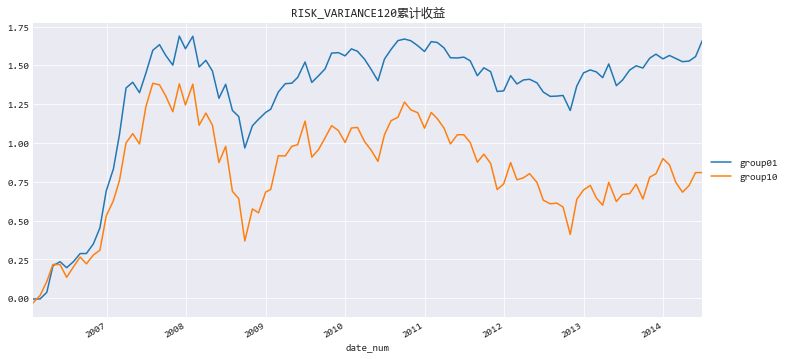

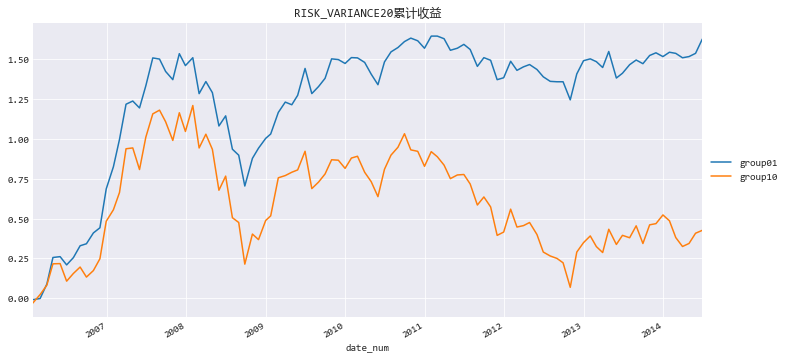

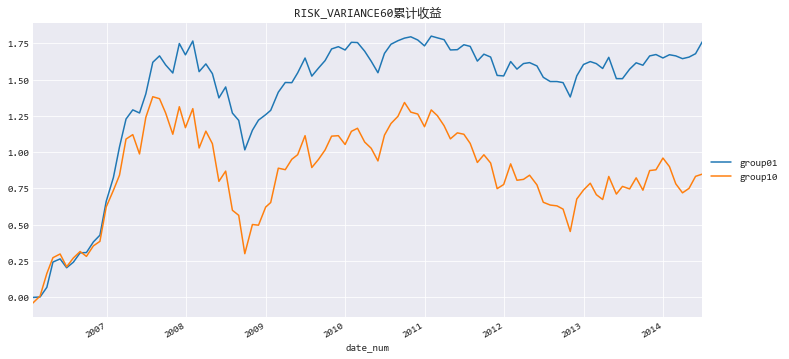

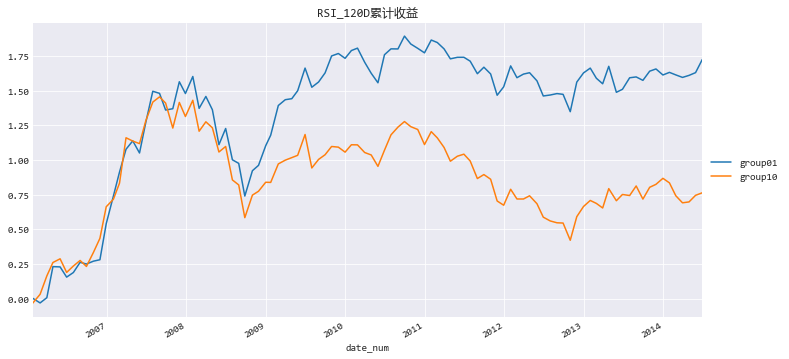

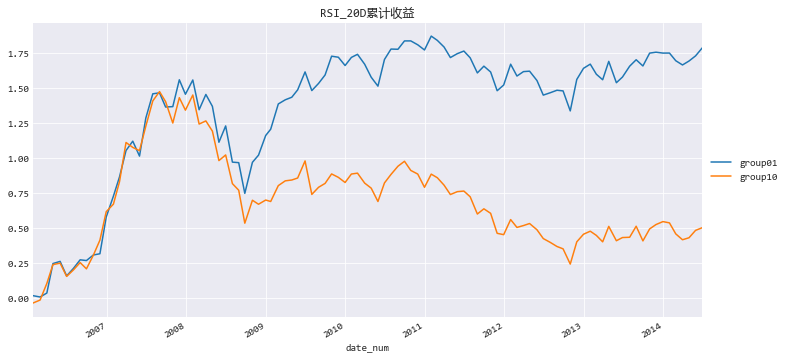

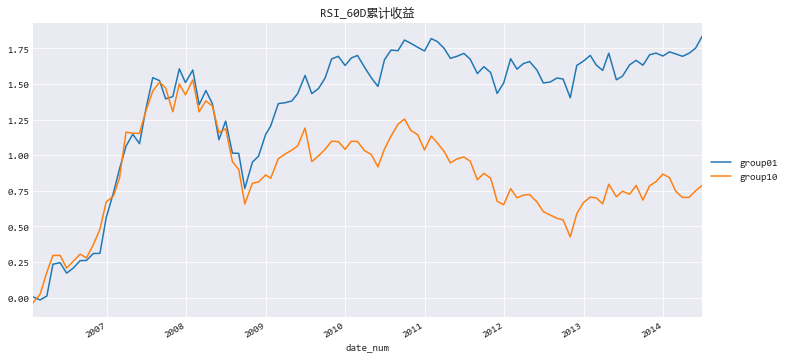

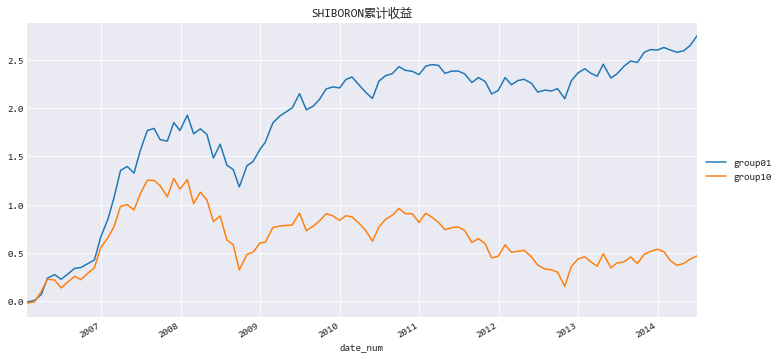

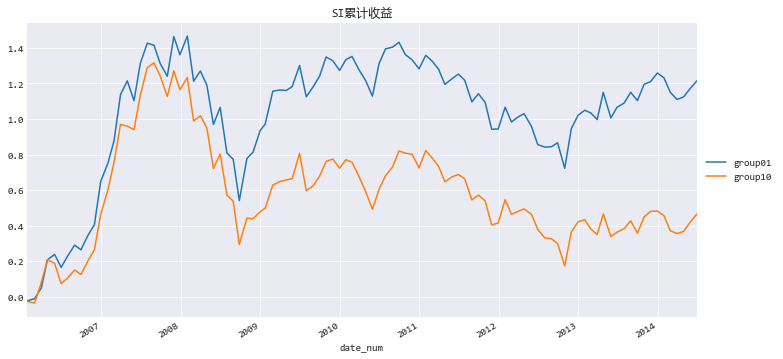

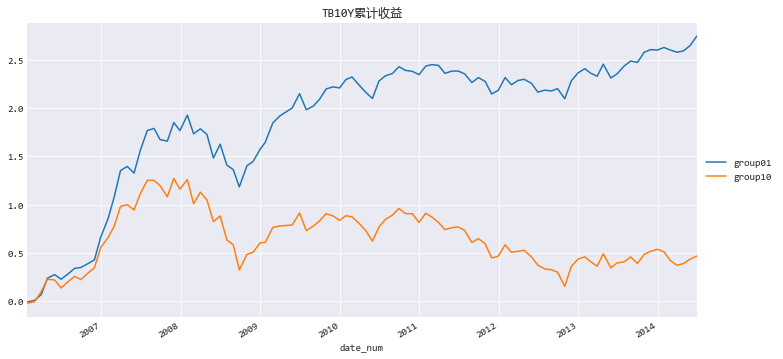

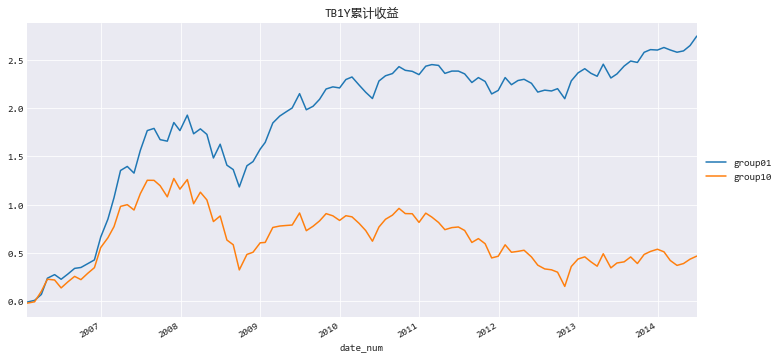

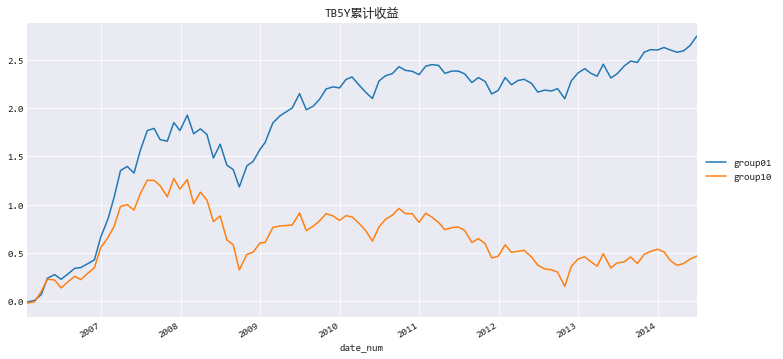

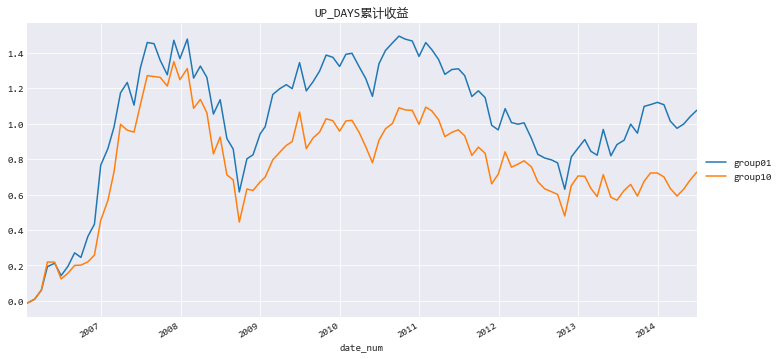

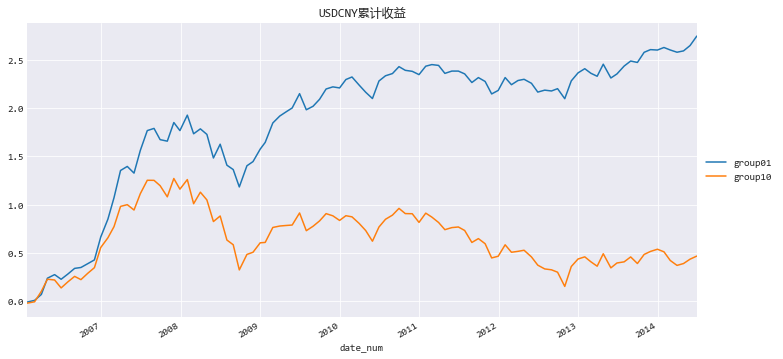

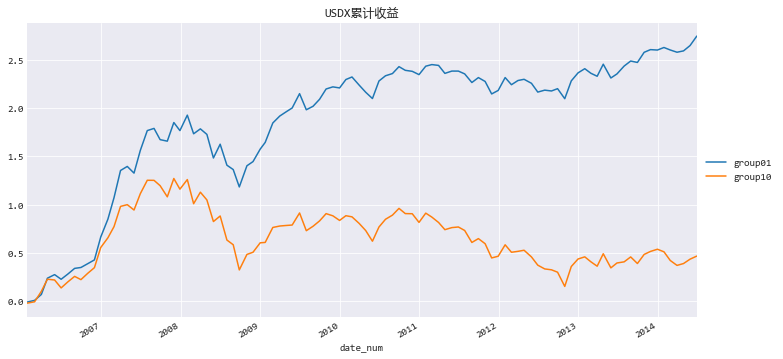

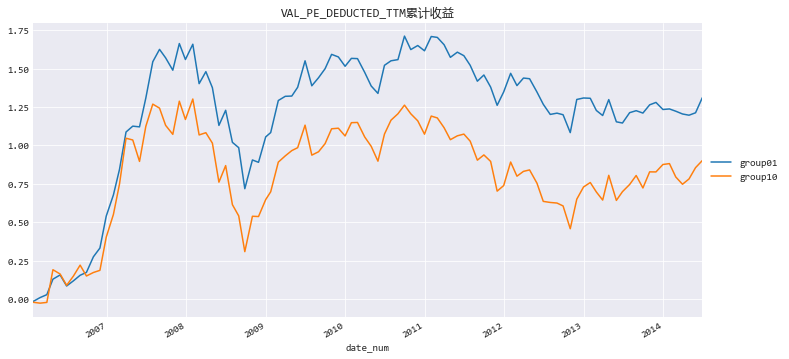

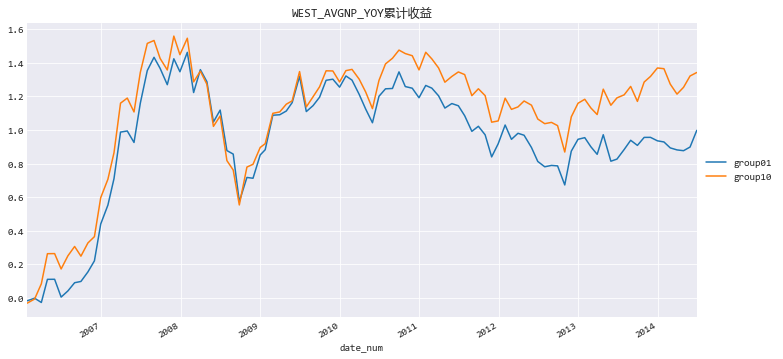

In [138]:
df_raw1 = df_raw[df_raw['date_num'].between('2006-01-25', '2014-07-31')]
ttest = {}
for feat in feats:
    print(feat)
    df_factor_test = df_raw1[['date', 'date_num', 'sec_id', feat, 'month_ret']]
    datelist = list(set(df_factor_test['date']))
    df_ret_by_group = pd.DataFrame()
    for date in datelist:
        close = factor.get_secs_index(index="close", trading_days=[date], sec_ids=df_raw1.sec_id.tolist())
        a = df_factor_test.merge(close, how='inner', on=['date', 'sec_id'])
        a = a[a['date'] == date]
        lower, upper = a[feat].quantile([0.05, 0.95])
        a = a[(a[feat] >= lower) & (a[feat] <= upper)]
        a = a.sort_values(by=feat)
        a["group"] = np.nan  # 表示缺失
        group_num = 10
        n_sample = a.shape[0]
        dist = int(n_sample / group_num)  # 每组个数
        col_index = a.columns.tolist().index("group")
        for j in range(group_num):
            if j < group_num - 1:
                a.iloc[j * dist:(j + 1) * dist, col_index] = j
            else:
                a.iloc[j * dist:, col_index] = j

        a['close_ending'] = a['close'] * (a['month_ret'] + 1)
        b = a.groupby(['group']).apply(lambda x: x['close_ending'].sum() / x['close'].sum() - 1).to_frame()
        b = b.transpose()
        b.columns = ['group{:0>2}'.format(i) for i in range(1, group_num + 1)]
        b[feat] = b['group10'] - b['group01']
        b['date'] = date
        df_ret_by_group = df_ret_by_group.append(b)
    ttest[feat] =  stats.ttest_rel(df_ret_by_group['group10'], df_ret_by_group['group01'])[1]
    df_ret_by_group['date_num'] = pd.to_datetime(df_ret_by_group['date'])
    df_ret_by_group = df_ret_by_group.set_index('date_num')
    df_ret_by_group = df_ret_by_group.sort_index()
    fig = plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    df_ret_by_group[['group01', 'group10']].cumsum().plot(ax=ax)
    ax.set_title("{}累计收益".format(feat))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    picfile = os.path.join(r"E:\07_data\02_factor\plot", "{}.png".format(feat))
    plt.savefig(picfile)
    print("plot is saved to: {}".format(picfile))

In [14]:
stats.ttest_rel(df_ret_by_group['group10'], df_ret_by_group['group01'])[1]

0.079032675117276449

In [141]:
dk.dict2json(ttest, r"E:\07_data\02_factor\ttest.json")

[INFO] 2018-08-22 23:52:04 Dict is saved to E:\07_data\02_factor\ttest.json.


In [3]:
ttest = dk.json2dict(r"E:\07_data\02_factor\ttest.json")

In [14]:
[k,v for k,v in ttest.items()]

SyntaxError: invalid syntax (<ipython-input-14-fec59f8c96d7>, line 1)

In [ ]:
SHIBORON TB10Y 

In [16]:
pd.DataFrame([[k,v] for k,v in ttest.items()], columns=['index', 'pvalue']).sort_values(['pvalue'])

,index,pvalue
26,SHIBORON,5.780828e-10
28,TB10Y,5.780828e-10
33,USDX,5.780828e-10
32,USDCNY,5.780828e-10
6,DR001,5.780828e-10
7,DR007,5.780828e-10
30,TB5Y,5.780828e-10
9,LPR1Y,5.780828e-10
29,TB1Y,5.780828e-10
10,MKT_CAP_FLOAT,3.215857e-03


In [44]:
df_ret_by_group[['group01', 'group10']]

,group01,group10
date_num,,
2006-04-28,0.214204,0.111501
2006-05-31,0.031221,0.008119
2006-11-30,0.008639,0.134068
2007-01-31,0.122516,0.070141
2007-04-30,0.069932,-0.009316
2007-06-29,0.254895,0.156894
2007-07-31,0.141505,0.201504
2008-03-31,0.113045,0.016941
2008-05-30,-0.258868,-0.247590


In [124]:
b

,group01,group02,group03,group04,group05,group06,group07,group08,group09,group10,BIAS_120D
0,0.985494,0.977971,0.981253,0.998894,0.978806,0.997394,0.971032,0.977292,0.967047,0.974545,-0.010949
